<h1>ZMGSN Lista 3. - Normalizing Flows (NF)</h1>

<h2>Opis zadania</h2>

W ramach zadania należy:
<ol>
<li>Zapoznać się z poniższym eksperymentem z wykorzystaniem modelu NICE (ang. Non-linear Independent Components Estimation)</li>
<li>Dokonać analizy wpływu hiperparametrów eksperymentu, np. kroku uczenia, rozmiaru pakietu (ang. <i>batch size</i>), liczby epok na wyniki modelu NICE (25 pkt)</li> 
<li>Dokonać modyfikacji architektury modelu NICE w celu zbadania wpływu architektury na wyniki (15 pkt)</li> 
<li>Dokonać ewaluacji innych wariantów sieci opartych o przepływy normalizacyjne, np. ConvFlow, MAF, IAF itp. (30 pkt)</li> 
<li>Opracować procedurę ewaluacji jakości działania modelu NICE i innych rozważanych wariantów, uwzględniającą różne metody wizualizacji (np. wykresy, miary, klasy), klasteryzacji, redukcji wymiarów (np. t-SNE) (30 pkt)</li>
</ol> 

Ocenie podlegać będzie jakość wykonania zadania, w tym:
<ol>
<li>Właściwe wykonanie zadań</li>
<li>Rzetelne opracowanie wyników, uwzględniające analizę jakościową i ilościową</li>
<li>Opracowanie wniosków mających na celu wyjaśnienie badanych zjawisk i uzyskanych wyników</li>
<li>Opracowanie i wyjaśnienie kodu źródłowego</li>
</ol>


<h2>Import używanych bibliotek</h2>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision

from keras.datasets.mnist import load_data
from tqdm import tqdm
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions.uniform import Uniform
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transforms import AffineTransform
from torch.utils.data import DataLoader
import pickle
from sklearn.manifold import TSNE

<h2>Inicjalizacja ziarna generatora liczb pseudolosowych</h2>

In [2]:
torch.manual_seed(0)

<h2>Określenie domyślnego urządzenia na podstawie sprawdzenia dostępności karty graficznej</h2>

In [3]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


<h2>Pobranie, rozpakowanie i normalizacja zbioru danych</h2>

In [4]:
(trainX, trainY), (testX, testy) = load_data()
trainX = (np.float32(trainX) + torch.rand(trainX.shape).numpy()) / 255.
trainX = trainX.clip(0, 1)
trainX = torch.tensor(trainX.reshape(-1, 28 * 28))

<h2>Deklaracja podstawowej klasy modelu NICE (ang. Non-linear Independent Component Estimation)<h2>

In [5]:
class NICE(nn.Module):

    def __init__(self, data_dim=28 * 28, hidden_dim=1000):
        super().__init__()

        self.m = torch.nn.ModuleList([nn.Sequential(
            nn.Linear(data_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, data_dim // 2), ) for i in range(4)])
        self.s = torch.nn.Parameter(torch.randn(data_dim))

    def forward(self, x):
        x = x.clone()
        for i in range(len(self.m)):
            x_i1 = x[:, ::2] if (i % 2) == 0 else x[:, 1::2]
            x_i2 = x[:, 1::2] if (i % 2) == 0 else x[:, ::2]
            h_i1 = x_i1
            h_i2 = x_i2 + self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = h_i1
            x[:, 1::2] = h_i2
        z = torch.exp(self.s) * x
        log_jacobian = torch.sum(self.s)
        return z, log_jacobian

    def invert(self, z):
        x = z.clone() / torch.exp(self.s)
        for i in range(len(self.m) - 1, -1, -1):
            h_i1 = x[:, ::2]
            h_i2 = x[:, 1::2]
            x_i1 = h_i1
            x_i2 = h_i2 - self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = x_i1 if (i % 2) == 0 else x_i2
            x[:, 1::2] = x_i2 if (i % 2) == 0 else x_i1
        return x

<h2>Definicja klasy reprezentującej standardowy rozkład logistyczny</h2>

In [6]:
class StandardLogisticDistribution:

    def __init__(self, data_dim=28 * 28, device='cpu'):
        self.m = TransformedDistribution(
            Uniform(torch.zeros(data_dim, device=device),
                    torch.ones(data_dim, device=device)),
            [SigmoidTransform().inv, AffineTransform(torch.zeros(data_dim, device=device),
                                                     torch.ones(data_dim, device=device))]
        )

    def log_pdf(self, z):
        return self.m.log_prob(z).sum(dim=1)

    def sample(self):
        return self.m.sample()

<h2>Przykładowa pętla ucząca</h2>

In [7]:
def training(normalizing_flow, optimizer, dataloader, distribution, epochs=100, device='cpu'):
    avg_loss_per_epoch = []
    for epoch in tqdm(range(epochs)):
        loss_list = []
        for batch in tqdm(dataloader):
            z, log_jacobian = normalizing_flow(batch.to(device))
            log_likelihood = distribution.log_pdf(z) + log_jacobian
            loss = -log_likelihood.sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())

        avg_loss = np.mean(loss_list)
        avg_loss_per_epoch.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], avg_loss: {avg_loss:.4f}")

    return avg_loss_per_epoch

<h2>Inicjalizacja sieci NICE i uruchomienie procesu uczenia</h2>

In [9]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=15,
                         device=device)

filename = 'nice.sav'
pickle.dump(normalizing_flow, open(filename, 'wb'))

  7%|▋         | 1/15 [00:25<05:58, 25.58s/it]

Epoch [1/15], avg_loss: 28341.2867


 13%|█▎        | 2/15 [00:51<05:31, 25.53s/it]

Epoch [2/15], avg_loss: 19442.8007


 20%|██        | 3/15 [01:17<05:08, 25.73s/it]

Epoch [3/15], avg_loss: 11085.5627


 27%|██▋       | 4/15 [01:42<04:41, 25.57s/it]

Epoch [4/15], avg_loss: 3194.2917


 33%|███▎      | 5/15 [02:07<04:15, 25.55s/it]

Epoch [5/15], avg_loss: -4221.1164


 40%|████      | 6/15 [02:35<03:55, 26.17s/it]

Epoch [6/15], avg_loss: -11125.0025


 47%|████▋     | 7/15 [02:58<03:22, 25.36s/it]

Epoch [7/15], avg_loss: -17518.1078


 53%|█████▎    | 8/15 [03:30<03:10, 27.21s/it]

Epoch [8/15], avg_loss: -23426.0165


 60%|██████    | 9/15 [04:08<03:04, 30.77s/it]

Epoch [9/15], avg_loss: -28820.1746


 67%|██████▋   | 10/15 [04:39<02:34, 30.92s/it]

Epoch [10/15], avg_loss: -33724.0836


 73%|███████▎  | 11/15 [05:08<02:00, 30.20s/it]

Epoch [11/15], avg_loss: -38158.9379


 80%|████████  | 12/15 [05:36<01:28, 29.61s/it]

Epoch [12/15], avg_loss: -42162.6236


 87%|████████▋ | 13/15 [06:04<00:58, 29.07s/it]

Epoch [13/15], avg_loss: -45762.2202


 93%|█████████▎| 14/15 [06:31<00:28, 28.48s/it]

Epoch [14/15], avg_loss: -48954.3514


100%|██████████| 15/15 [06:58<00:00, 27.92s/it]

Epoch [15/15], avg_loss: -51741.5643


<h2>Podstawowa wizualizacja obrazów generowanych przez wyuczony model </h2>

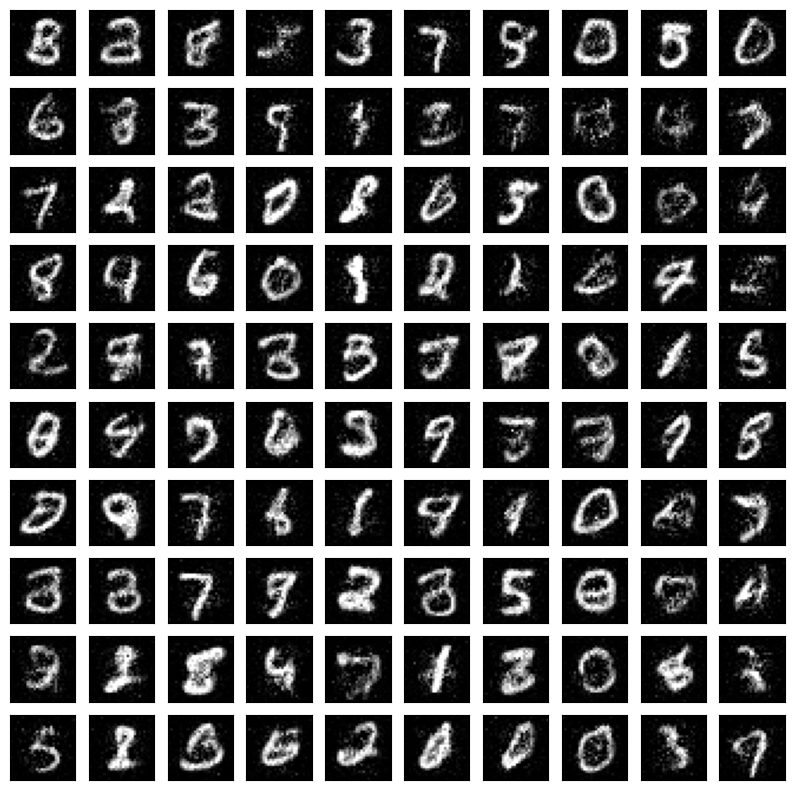

In [14]:
nb_data = 10
fig, axs = plt.subplots(nb_data, nb_data, figsize=(10, 10))
for i in range(nb_data):
    for j in range(nb_data):
        x = normalizing_flow.invert(logistic_distribution.sample().unsqueeze(0)).data.cpu().numpy()
        axs[i, j].imshow(x.reshape(28, 28).clip(0, 1), cmap='gray')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
plt.savefig('NF_Generated_MNIST_data.png')
plt.show()

Zadanie 2

In [31]:
import matplotlib.gridspec as gridspec

def plot_loss_and_images(training_loss, normalizing_flow, logistic_distribution, title, nb_data=10):
    fig = plt.figure(figsize=(20, 10))


    ax1 = fig.add_subplot(1, 2, 1)  

    ax1.plot(training_loss)
    ax1.set_yscale('symlog') 
    ax1.set_title(f'Average Loss - {title}')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Average Loss (SymLog Scale)')

    outer_grid = gridspec.GridSpec(1, 2, wspace=0.0, hspace=0.0)[1]

    inner_grid = gridspec.GridSpecFromSubplotSpec(nb_data, nb_data, subplot_spec=outer_grid, wspace=0.0, hspace=0.0)

    for i in range(nb_data*nb_data):
        ax = plt.Subplot(fig, inner_grid[i])
        x = normalizing_flow.invert(logistic_distribution.sample().unsqueeze(0)).data.cpu().numpy()
        ax.imshow(x.reshape(28, 28).clip(0, 1), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

    plt.suptitle('Generated Images')

    plt.tight_layout()
    plt.savefig(f'{title}_NF_Training_and_Generated_Images.png')
    plt.show()

 10%|█         | 1/10 [02:32<22:49, 152.13s/it]

Epoch [1/10], avg_loss: 32267.4724


 20%|██        | 2/10 [05:04<20:17, 152.18s/it]

Epoch [2/10], avg_loss: 27521.5062


 30%|███       | 3/10 [07:37<17:47, 152.56s/it]

Epoch [3/10], avg_loss: 23045.5728


 40%|████      | 4/10 [10:10<15:16, 152.73s/it]

Epoch [4/10], avg_loss: 18663.1401


 50%|█████     | 5/10 [12:43<12:44, 152.86s/it]

Epoch [5/10], avg_loss: 14369.0770


 60%|██████    | 6/10 [15:16<10:11, 152.96s/it]

Epoch [6/10], avg_loss: 10173.0746


 70%|███████   | 7/10 [17:50<07:40, 153.38s/it]

Epoch [7/10], avg_loss: 6089.5081


 80%|████████  | 8/10 [20:23<05:06, 153.09s/it]

Epoch [8/10], avg_loss: 2136.9417


 90%|█████████ | 9/10 [22:56<02:33, 153.12s/it]

Epoch [9/10], avg_loss: -1692.4608


100%|██████████| 10/10 [25:35<00:00, 153.54s/it]


Epoch [10/10], avg_loss: -5391.8626


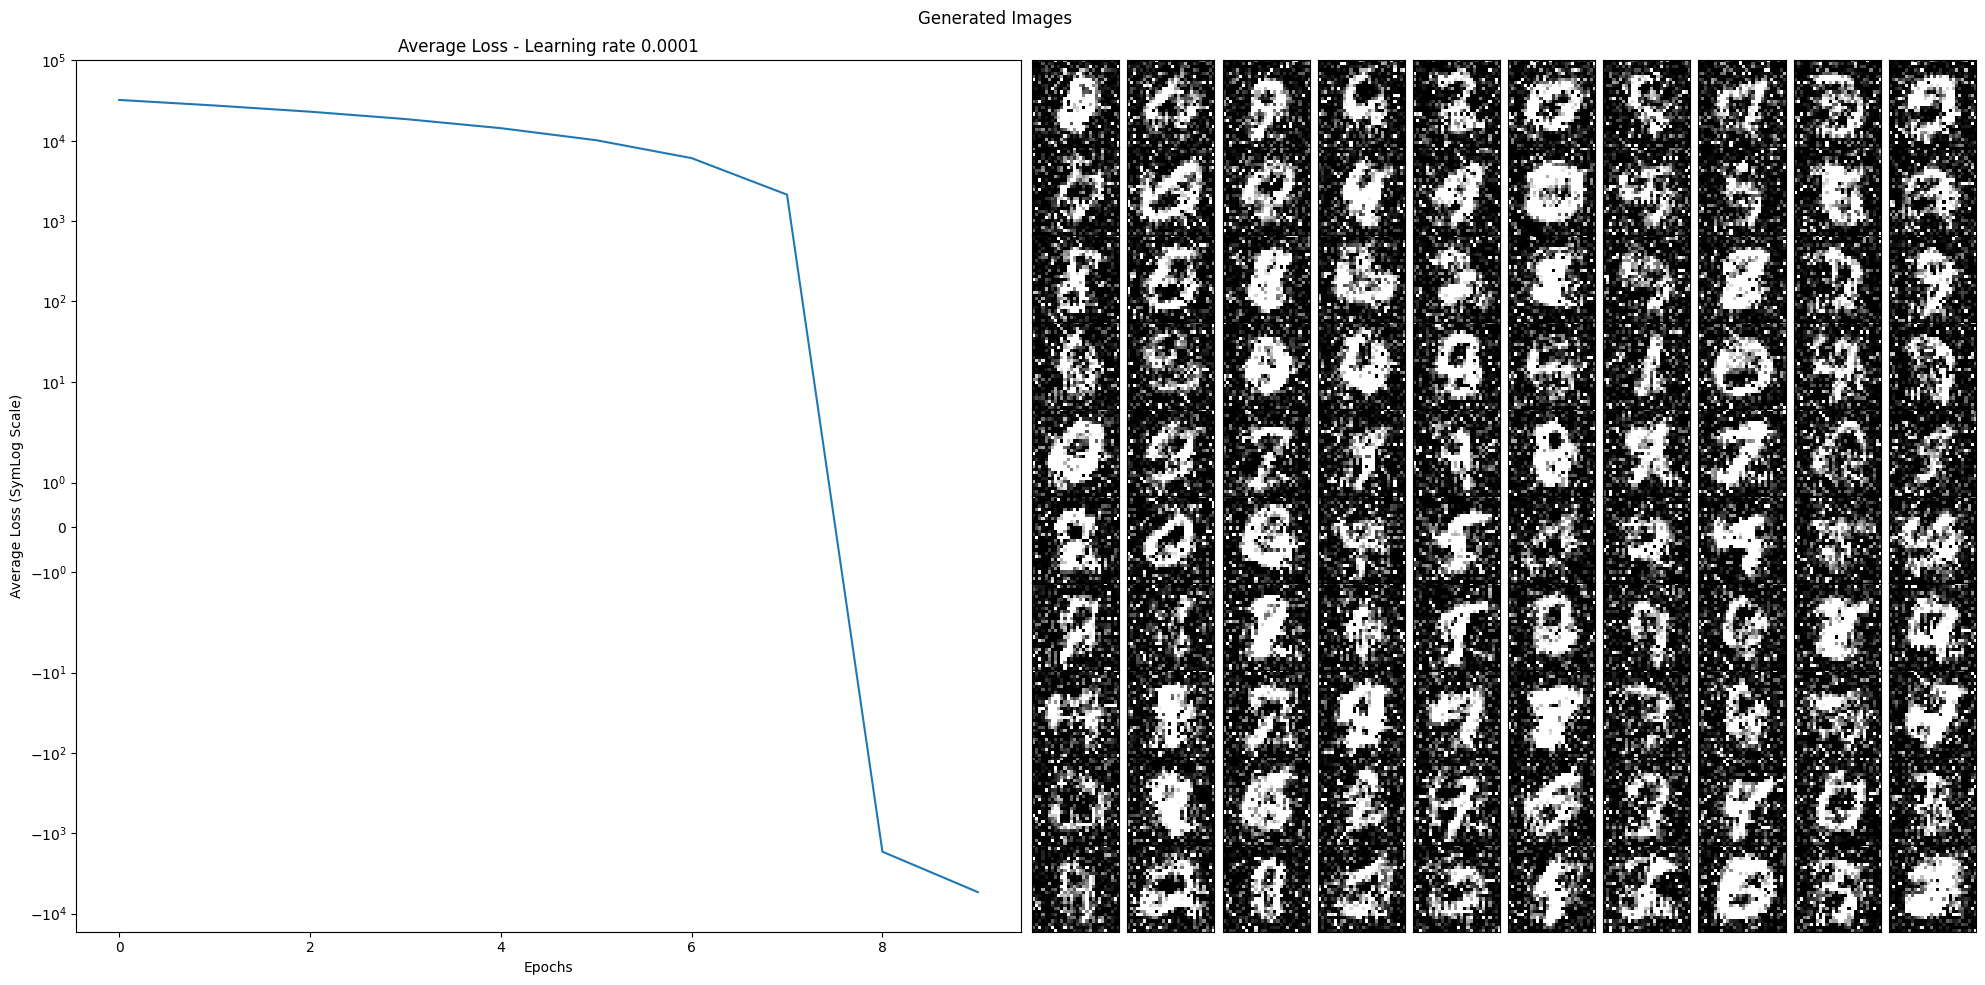

 10%|█         | 1/10 [02:25<21:46, 145.18s/it]

Epoch [1/10], avg_loss: 14946.5596


 20%|██        | 2/10 [04:48<19:11, 143.95s/it]

Epoch [2/10], avg_loss: -17725.9407


 30%|███       | 3/10 [07:12<16:48, 144.08s/it]

Epoch [3/10], avg_loss: -37964.0469


 40%|████      | 4/10 [09:48<14:51, 148.65s/it]

Epoch [4/10], avg_loss: -48879.3301


 50%|█████     | 5/10 [12:20<12:29, 149.92s/it]

Epoch [5/10], avg_loss: -53312.2482


 60%|██████    | 6/10 [15:02<10:16, 154.01s/it]

Epoch [6/10], avg_loss: -54888.3451


 70%|███████   | 7/10 [16:44<06:50, 136.91s/it]

Epoch [7/10], avg_loss: -55636.0857


 80%|████████  | 8/10 [17:13<03:25, 102.83s/it]

Epoch [8/10], avg_loss: -56079.5534


 90%|█████████ | 9/10 [18:08<01:27, 87.85s/it] 

Epoch [9/10], avg_loss: -56433.9397


100%|██████████| 10/10 [19:00<00:00, 114.02s/it]


Epoch [10/10], avg_loss: -56720.8097


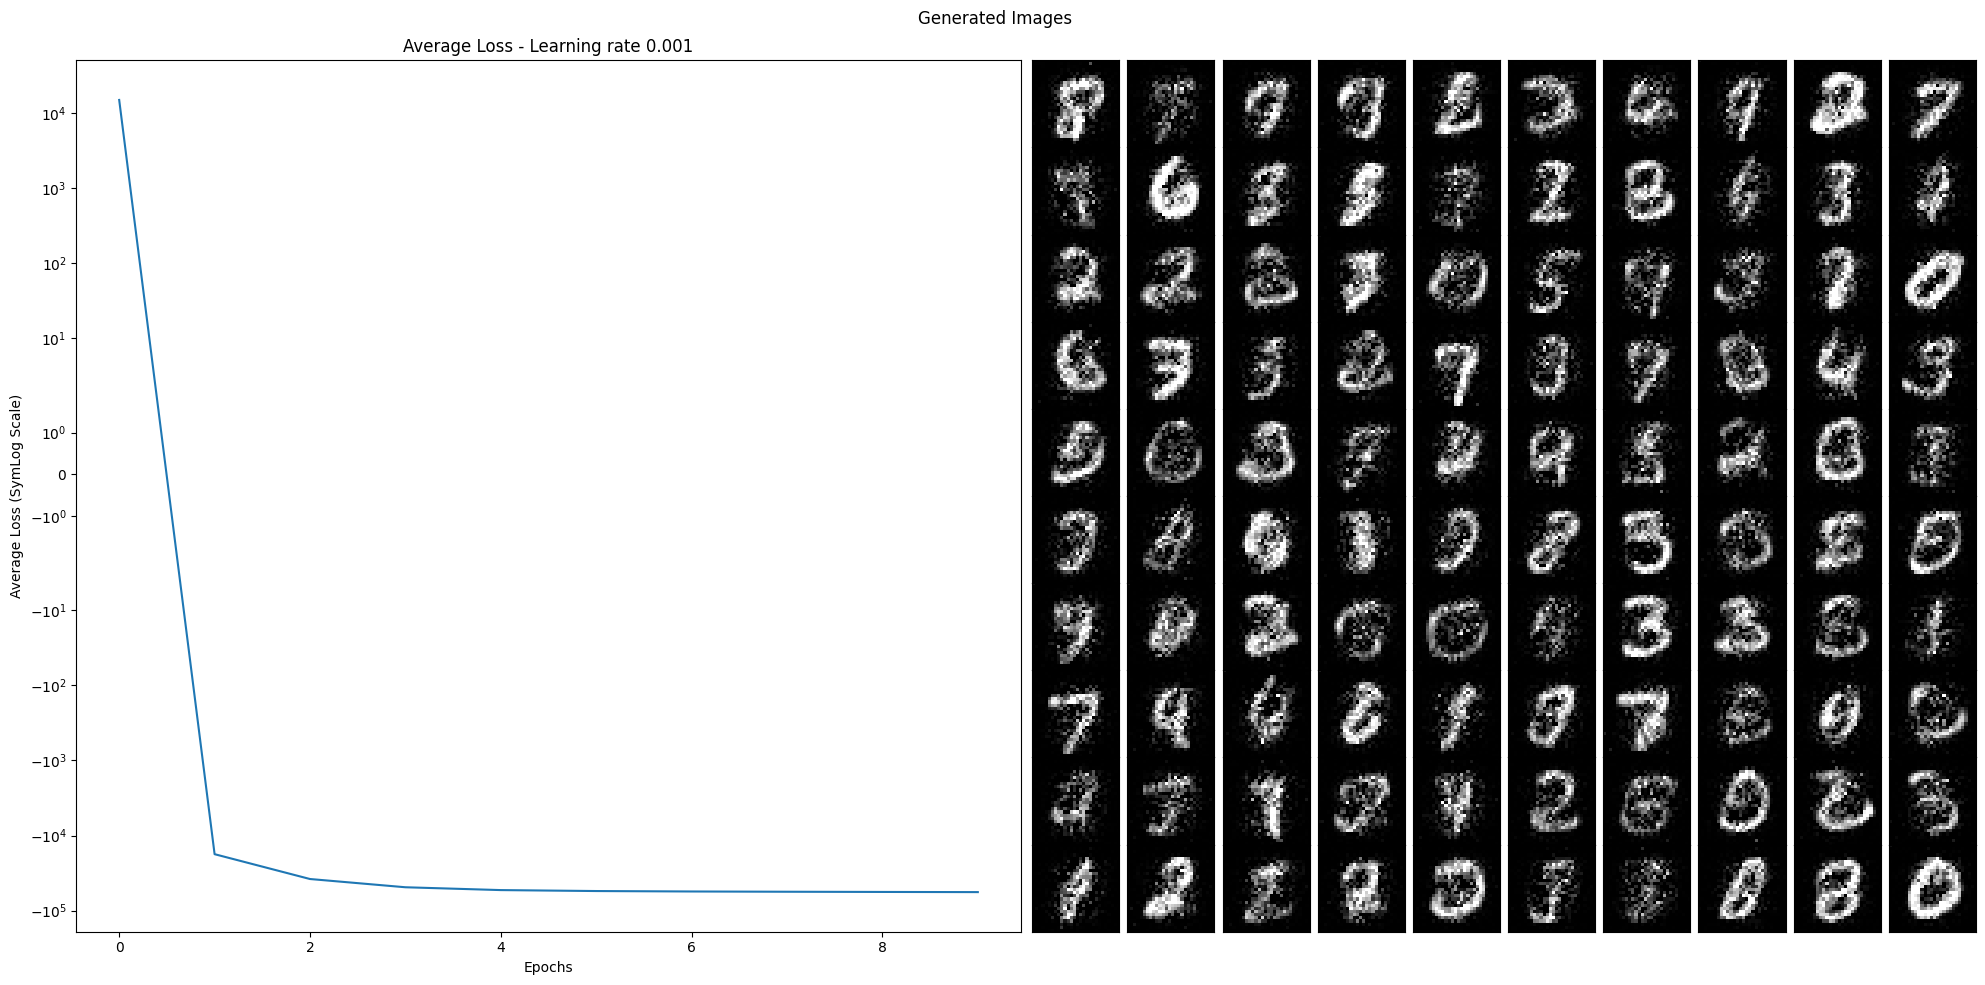

 10%|█         | 1/10 [00:53<07:57, 53.03s/it]

Epoch [1/10], avg_loss: 6126680705552007.0000


 20%|██        | 2/10 [01:47<07:11, 53.88s/it]

Epoch [2/10], avg_loss: 11522119418541840.0000


 30%|███       | 3/10 [02:40<06:14, 53.55s/it]

Epoch [3/10], avg_loss: 12752535993497678.0000


 40%|████      | 4/10 [03:32<05:17, 52.89s/it]

Epoch [4/10], avg_loss: 40287501737491677184.0000


 50%|█████     | 5/10 [04:24<04:22, 52.43s/it]

Epoch [5/10], avg_loss: 118679161787561132032.0000


 60%|██████    | 6/10 [05:13<03:25, 51.25s/it]

Epoch [6/10], avg_loss: 17867251161594019840.0000


 70%|███████   | 7/10 [06:02<02:31, 50.57s/it]

Epoch [7/10], avg_loss: 54779236731592876032.0000


 80%|████████  | 8/10 [06:50<01:39, 49.68s/it]

Epoch [8/10], avg_loss: 13546561497603785097216.0000


 90%|█████████ | 9/10 [07:36<00:48, 48.68s/it]

Epoch [9/10], avg_loss: 34256705683843534848.0000


100%|██████████| 10/10 [08:22<00:00, 50.21s/it]


Epoch [10/10], avg_loss: 2243716641322959110144.0000


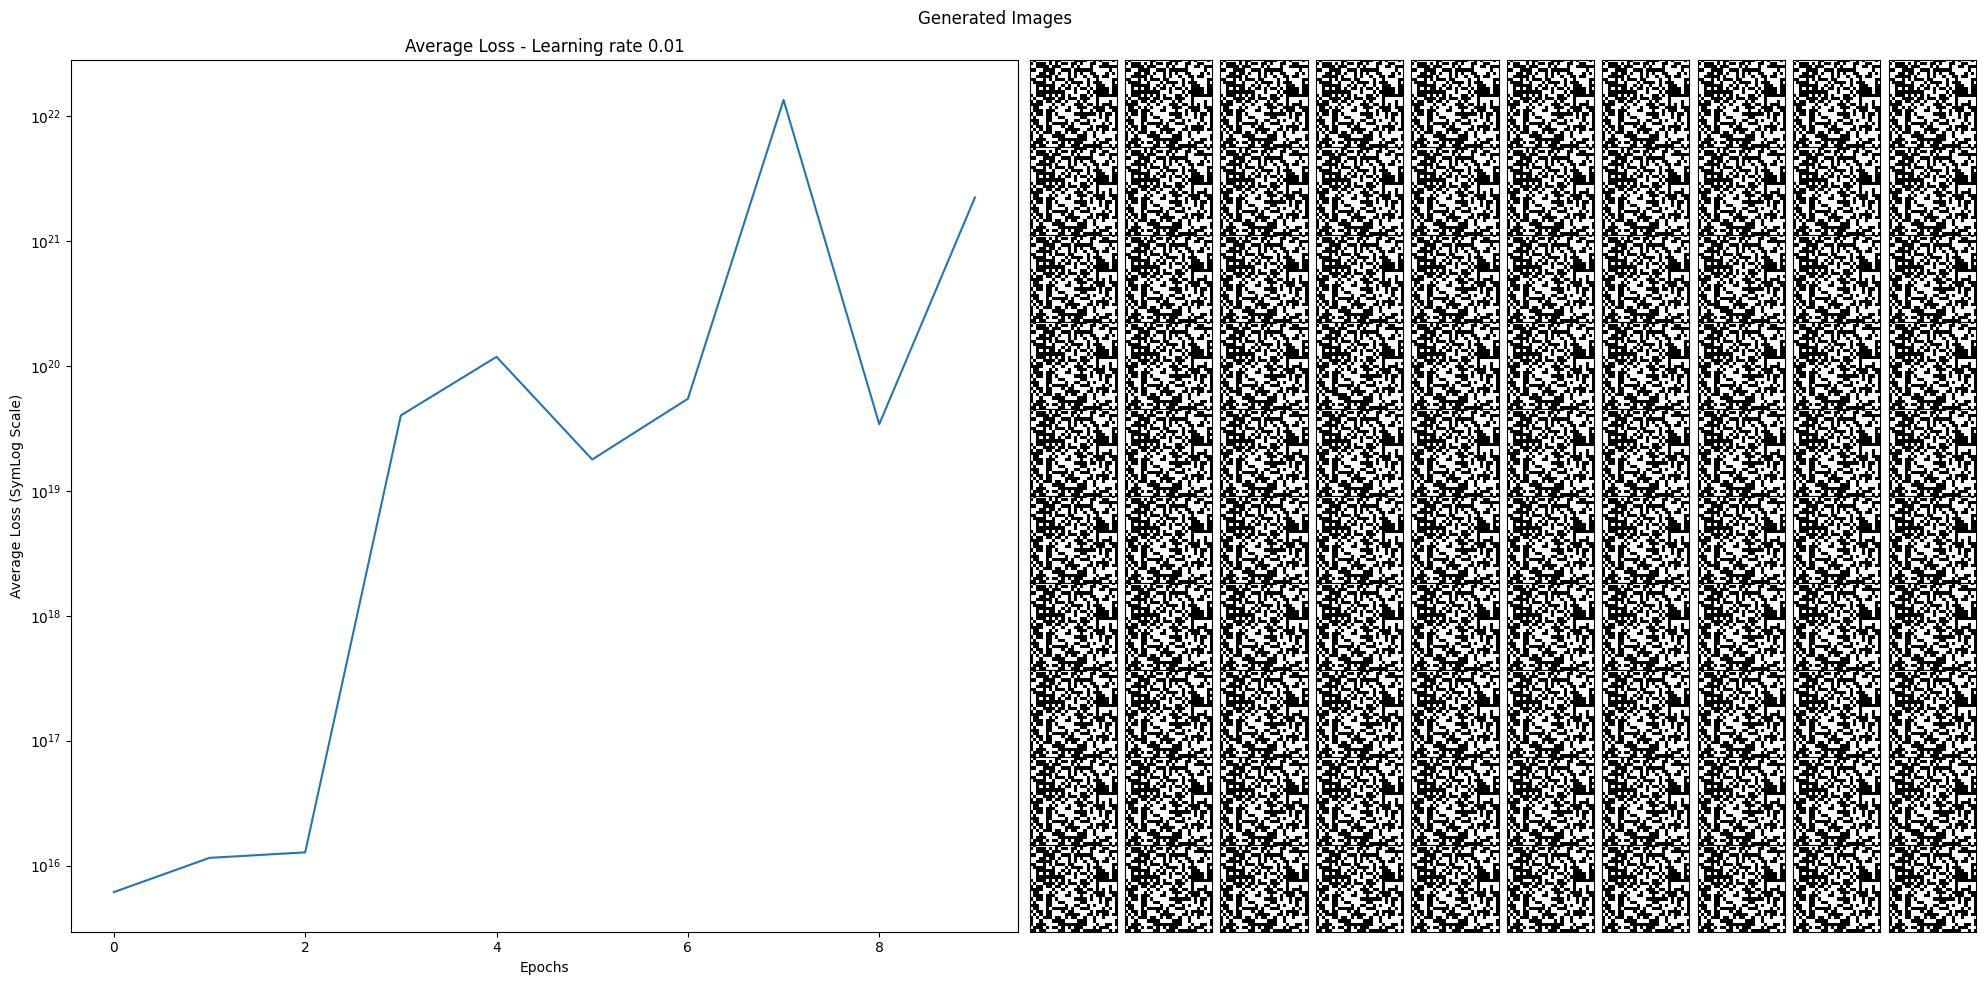

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

learning_rates = [0.0001, 0.001, 0.01]
for lr in learning_rates:
    normalizing_flow = NICE().to(device)
    optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=lr, weight_decay=0.9)
    dataloader = DataLoader(trainX, batch_size=32, shuffle=True)
    logistic_distribution = StandardLogisticDistribution(device=device)
    training_loss = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=10, device=device)
    plot_loss_and_images(training_loss, normalizing_flow, logistic_distribution, f"Learning rate {lr}")

 10%|█         | 1/10 [00:49<07:26, 49.59s/it]

Epoch [1/10], avg_loss: 14730.1930


 20%|██        | 2/10 [02:07<08:50, 66.31s/it]

Epoch [2/10], avg_loss: 6507.4221


 30%|███       | 3/10 [03:56<10:00, 85.77s/it]

Epoch [3/10], avg_loss: -712.6775


 40%|████      | 4/10 [05:44<09:27, 94.54s/it]

Epoch [4/10], avg_loss: -6863.0327


 50%|█████     | 5/10 [07:28<08:08, 97.79s/it]

Epoch [5/10], avg_loss: -11930.0917


 60%|██████    | 6/10 [09:12<06:40, 100.04s/it]

Epoch [6/10], avg_loss: -16101.3590


 70%|███████   | 7/10 [10:56<05:03, 101.29s/it]

Epoch [7/10], avg_loss: -19486.1325


 80%|████████  | 8/10 [12:39<03:23, 101.94s/it]

Epoch [8/10], avg_loss: -22149.6078


 90%|█████████ | 9/10 [14:22<01:42, 102.35s/it]

Epoch [9/10], avg_loss: -24149.3721


100%|██████████| 10/10 [16:05<00:00, 96.60s/it] 


Epoch [10/10], avg_loss: -25526.9282


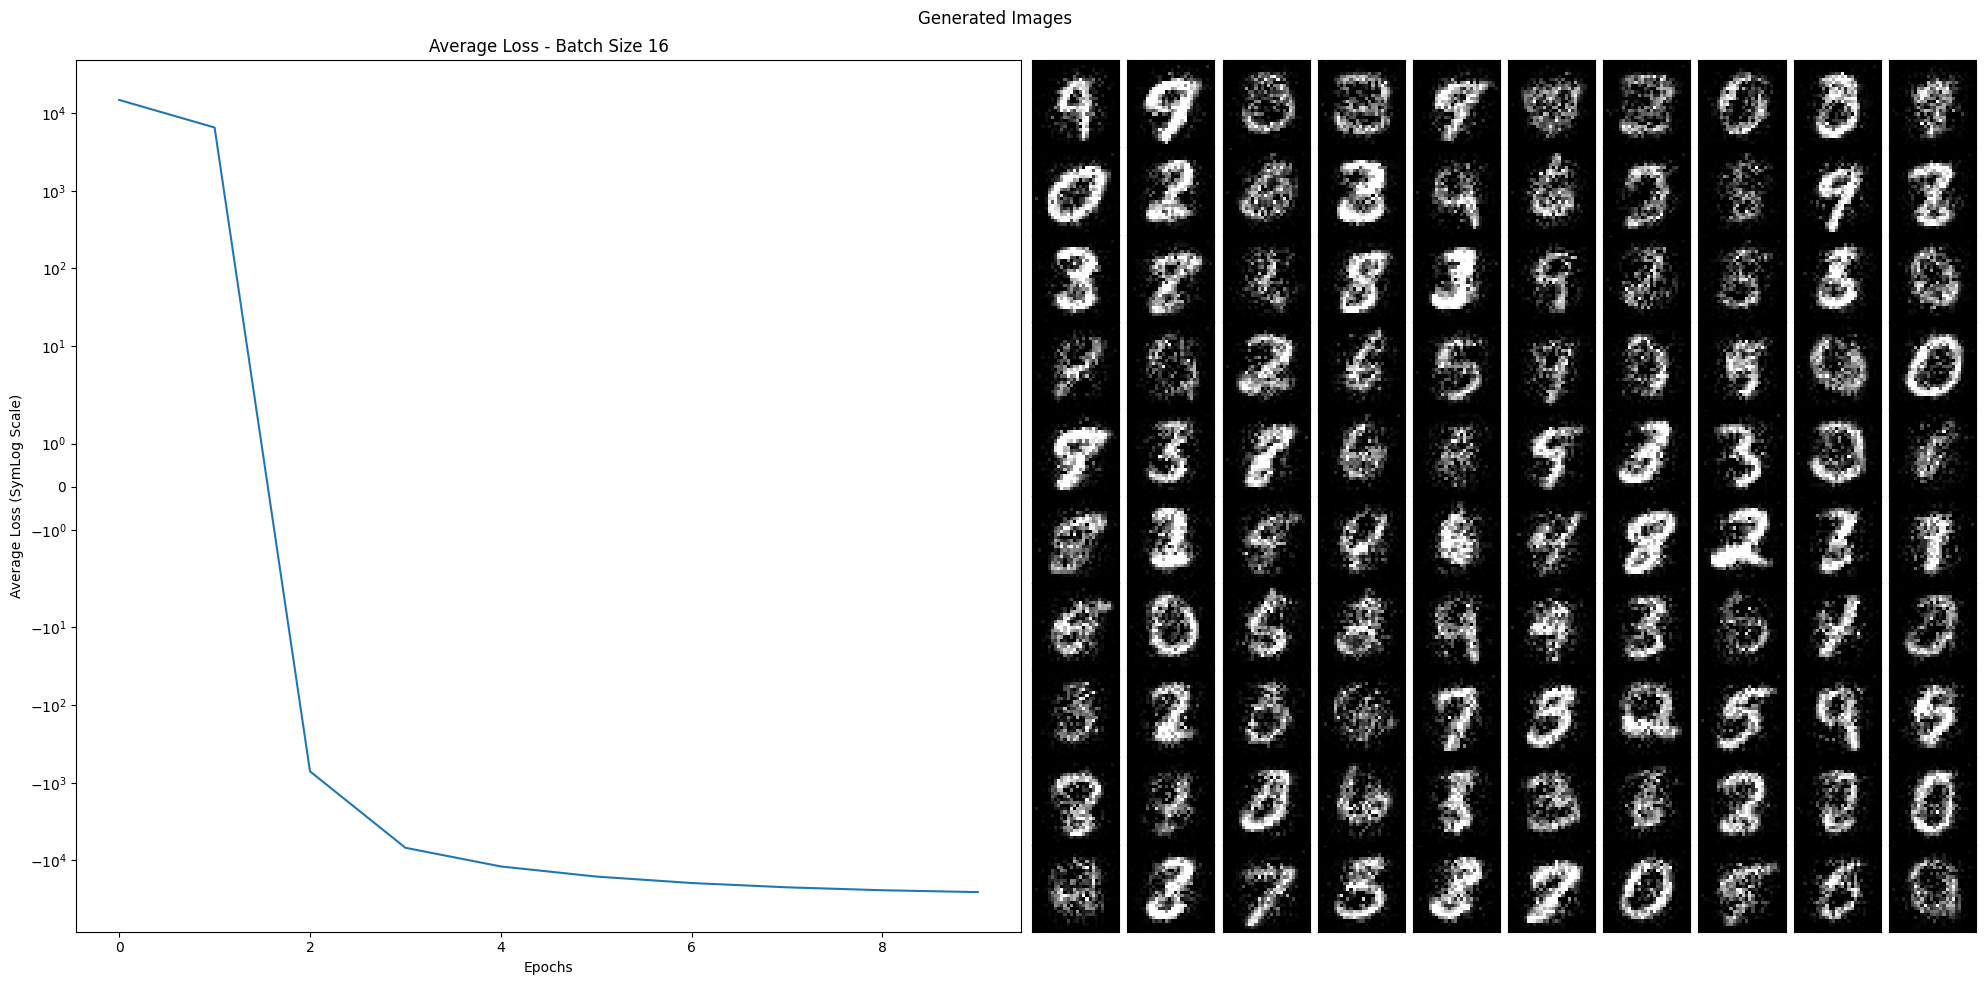

 10%|█         | 1/10 [20:02<3:00:18, 1202.03s/it]

Epoch [1/10], avg_loss: 32160.6745


 20%|██        | 2/10 [20:30<1:08:12, 511.53s/it] 

Epoch [2/10], avg_loss: 23195.2622


 30%|███       | 3/10 [21:07<34:26, 295.19s/it]  

Epoch [3/10], avg_loss: 14739.5736


 40%|████      | 4/10 [22:02<20:01, 200.24s/it]

Epoch [4/10], avg_loss: 6726.8294


 50%|█████     | 5/10 [22:57<12:18, 147.77s/it]

Epoch [5/10], avg_loss: -810.2064


 60%|██████    | 6/10 [23:51<07:44, 116.01s/it]

Epoch [6/10], avg_loss: -7844.0711


 70%|███████   | 7/10 [24:46<04:47, 95.98s/it] 

Epoch [7/10], avg_loss: -14420.8488


 80%|████████  | 8/10 [25:41<02:45, 82.85s/it]

Epoch [8/10], avg_loss: -20562.0345


 90%|█████████ | 9/10 [26:35<01:14, 74.06s/it]

Epoch [9/10], avg_loss: -26228.1195


100%|██████████| 10/10 [27:30<00:00, 165.06s/it]


Epoch [10/10], avg_loss: -31366.5928


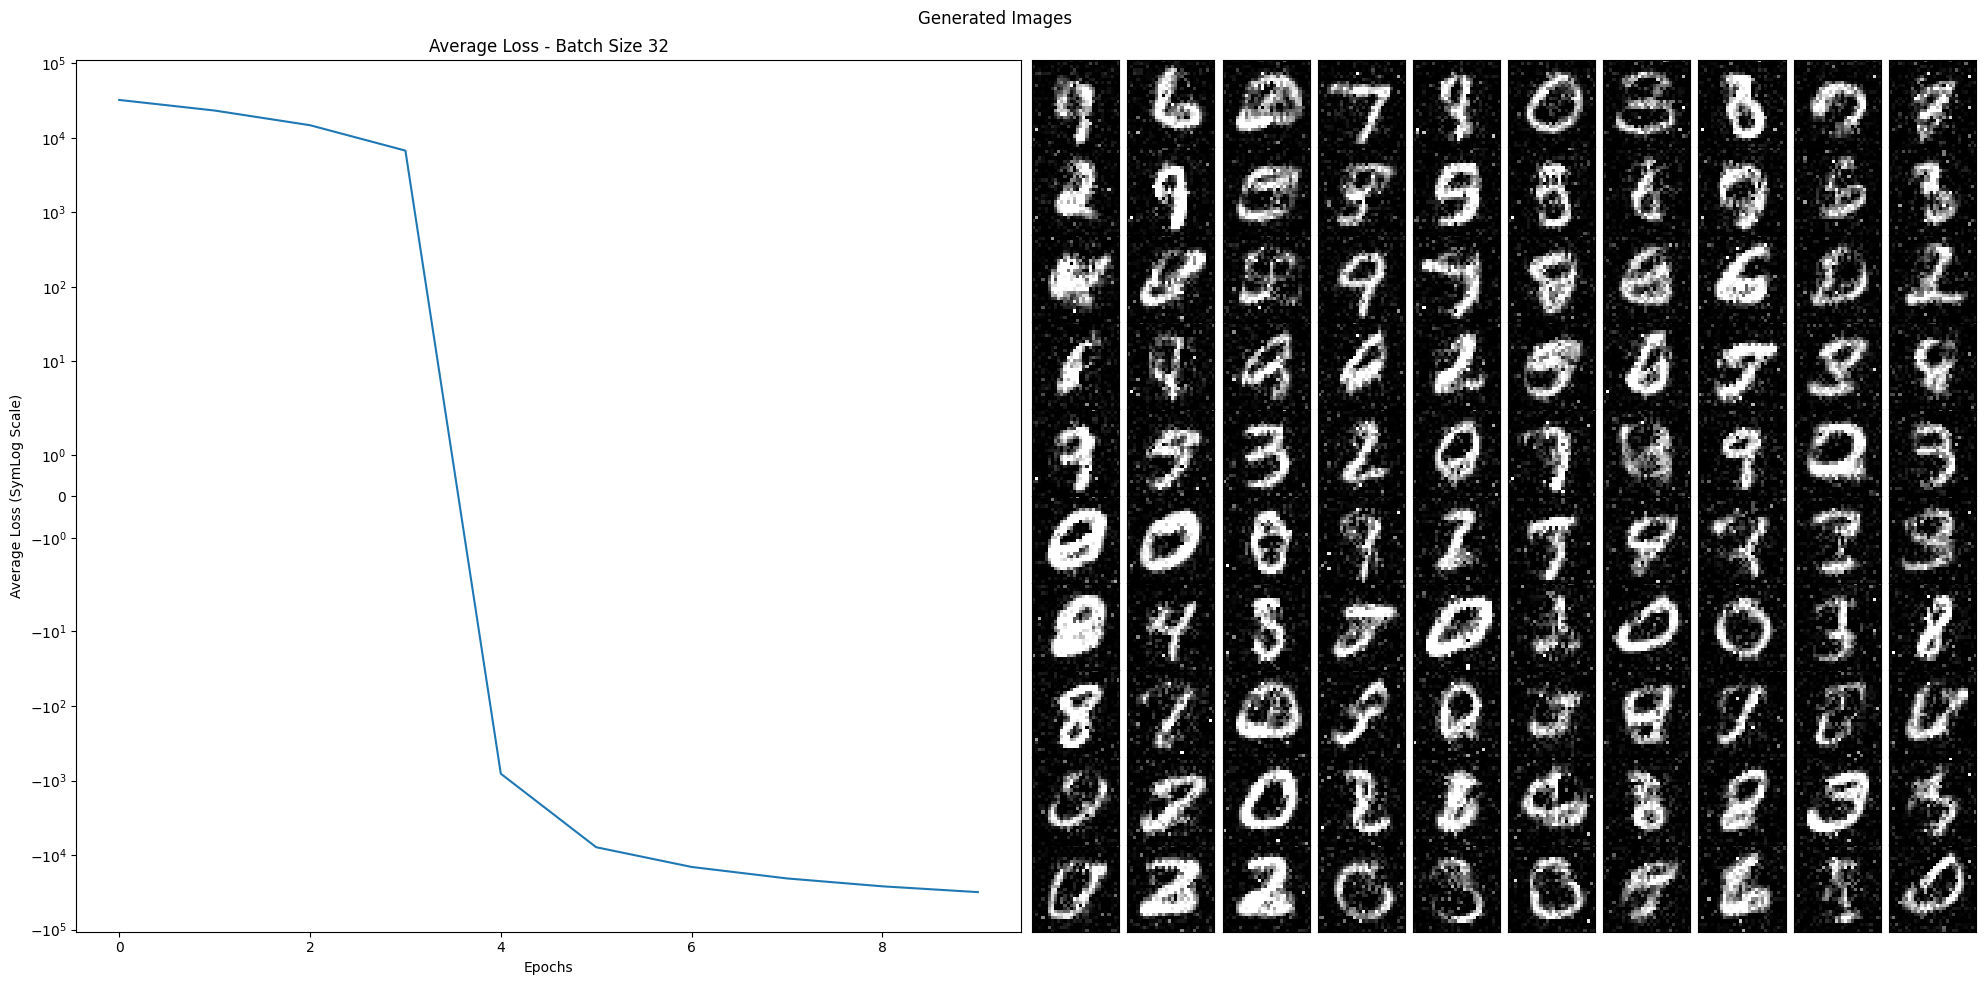

 10%|█         | 1/10 [00:27<04:09, 27.77s/it]

Epoch [1/10], avg_loss: 64951.8785


 20%|██        | 2/10 [00:55<03:42, 27.80s/it]

Epoch [2/10], avg_loss: 55282.4950


 30%|███       | 3/10 [01:23<03:13, 27.65s/it]

Epoch [3/10], avg_loss: 46203.5962


 40%|████      | 4/10 [01:50<02:45, 27.60s/it]

Epoch [4/10], avg_loss: 37298.2966


 50%|█████     | 5/10 [02:18<02:17, 27.60s/it]

Epoch [5/10], avg_loss: 28568.7622


 60%|██████    | 6/10 [02:45<01:50, 27.60s/it]

Epoch [6/10], avg_loss: 20029.3149


 70%|███████   | 7/10 [03:13<01:22, 27.51s/it]

Epoch [7/10], avg_loss: 11685.9916


 80%|████████  | 8/10 [03:40<00:55, 27.55s/it]

Epoch [8/10], avg_loss: 3565.0417


 90%|█████████ | 9/10 [04:08<00:27, 27.54s/it]

Epoch [9/10], avg_loss: -4318.5592


100%|██████████| 10/10 [04:35<00:00, 27.57s/it]


Epoch [10/10], avg_loss: -11965.8291


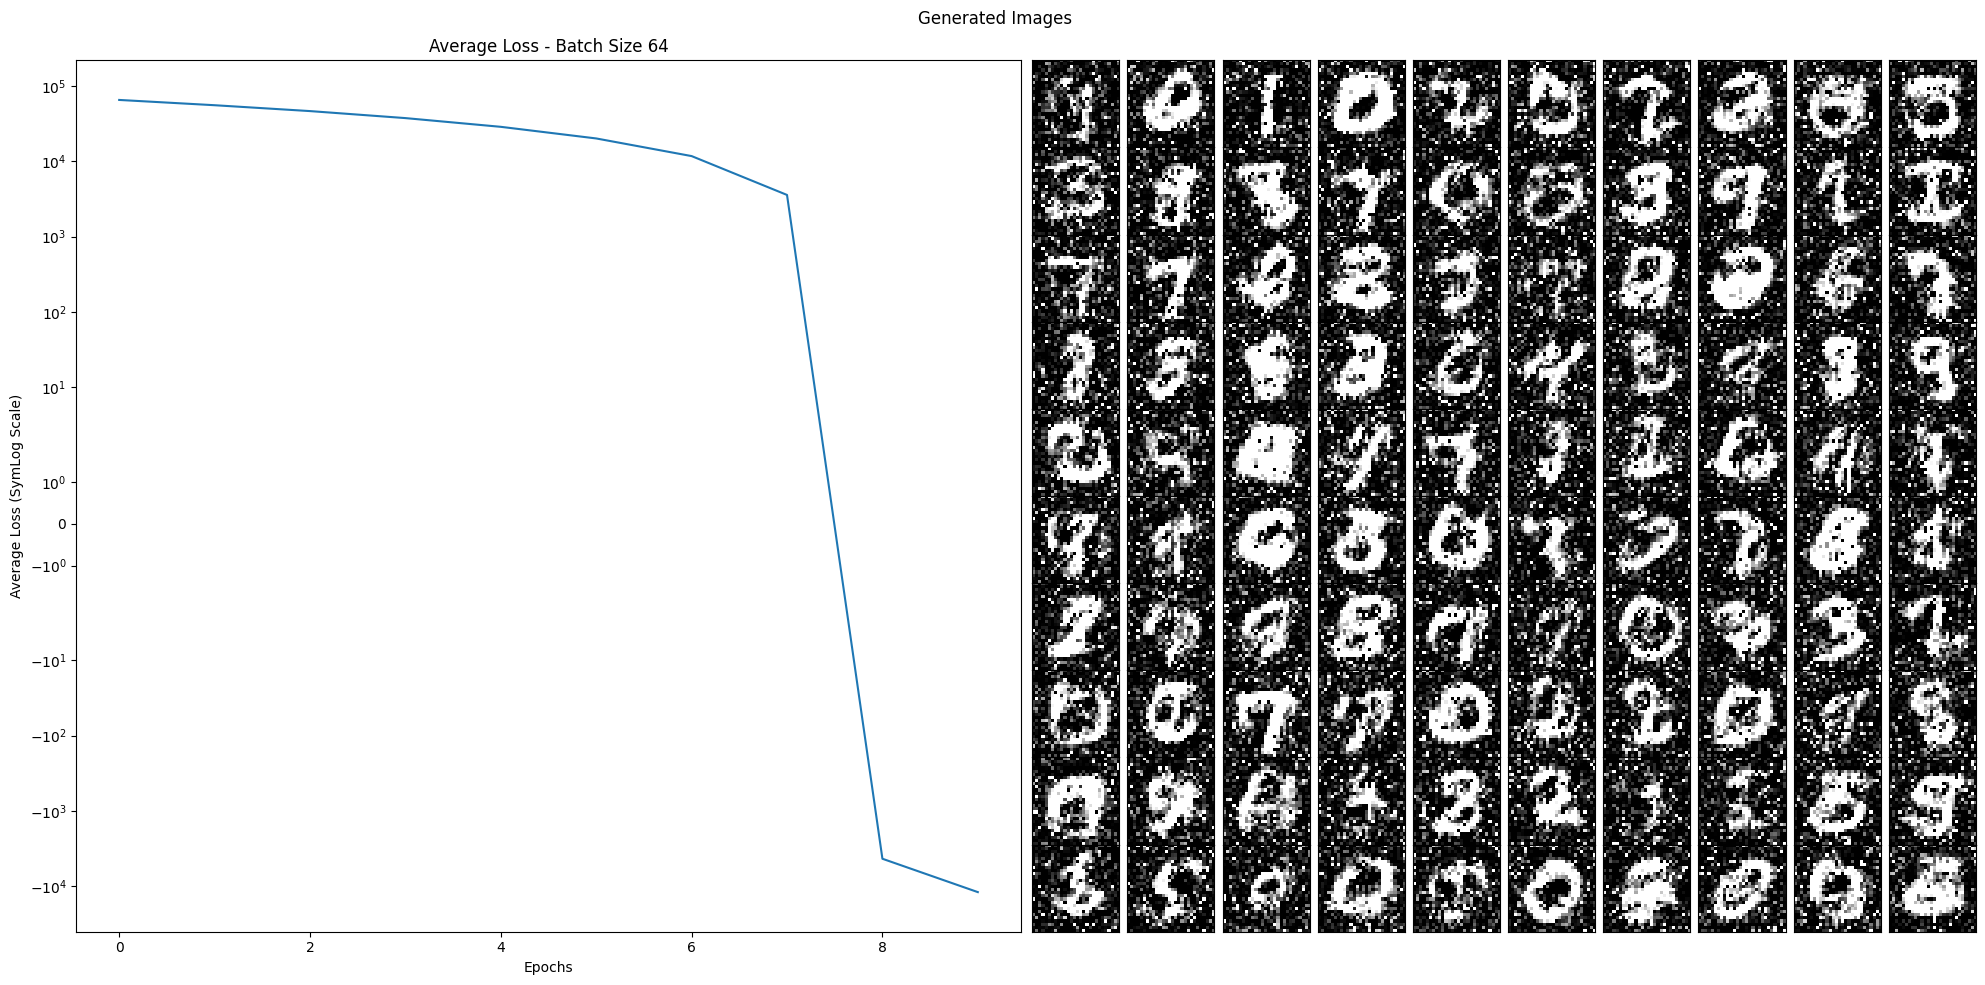

In [49]:
batch_sizes = [16, 32, 64]
for batch_size in batch_sizes:
    normalizing_flow = NICE().to(device)
    optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
    dataloader = DataLoader(trainX, batch_size=batch_size, shuffle=True)
    logistic_distribution = StandardLogisticDistribution(device=device)
    training_loss = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=10, device=device)
    plot_loss_and_images(training_loss, normalizing_flow, logistic_distribution, f"Batch Size {batch_size}")

 20%|██        | 1/5 [00:26<01:46, 26.72s/it]

Epoch [1/5], avg_loss: 31189.6718


 40%|████      | 2/5 [01:05<01:41, 33.80s/it]

Epoch [2/5], avg_loss: 22248.2594


 60%|██████    | 3/5 [01:59<01:26, 43.02s/it]

Epoch [3/5], avg_loss: 13821.1759


 80%|████████  | 4/5 [02:52<00:47, 47.16s/it]

Epoch [4/5], avg_loss: 5847.0122


100%|██████████| 5/5 [03:46<00:00, 45.33s/it]


Epoch [5/5], avg_loss: -1685.9119


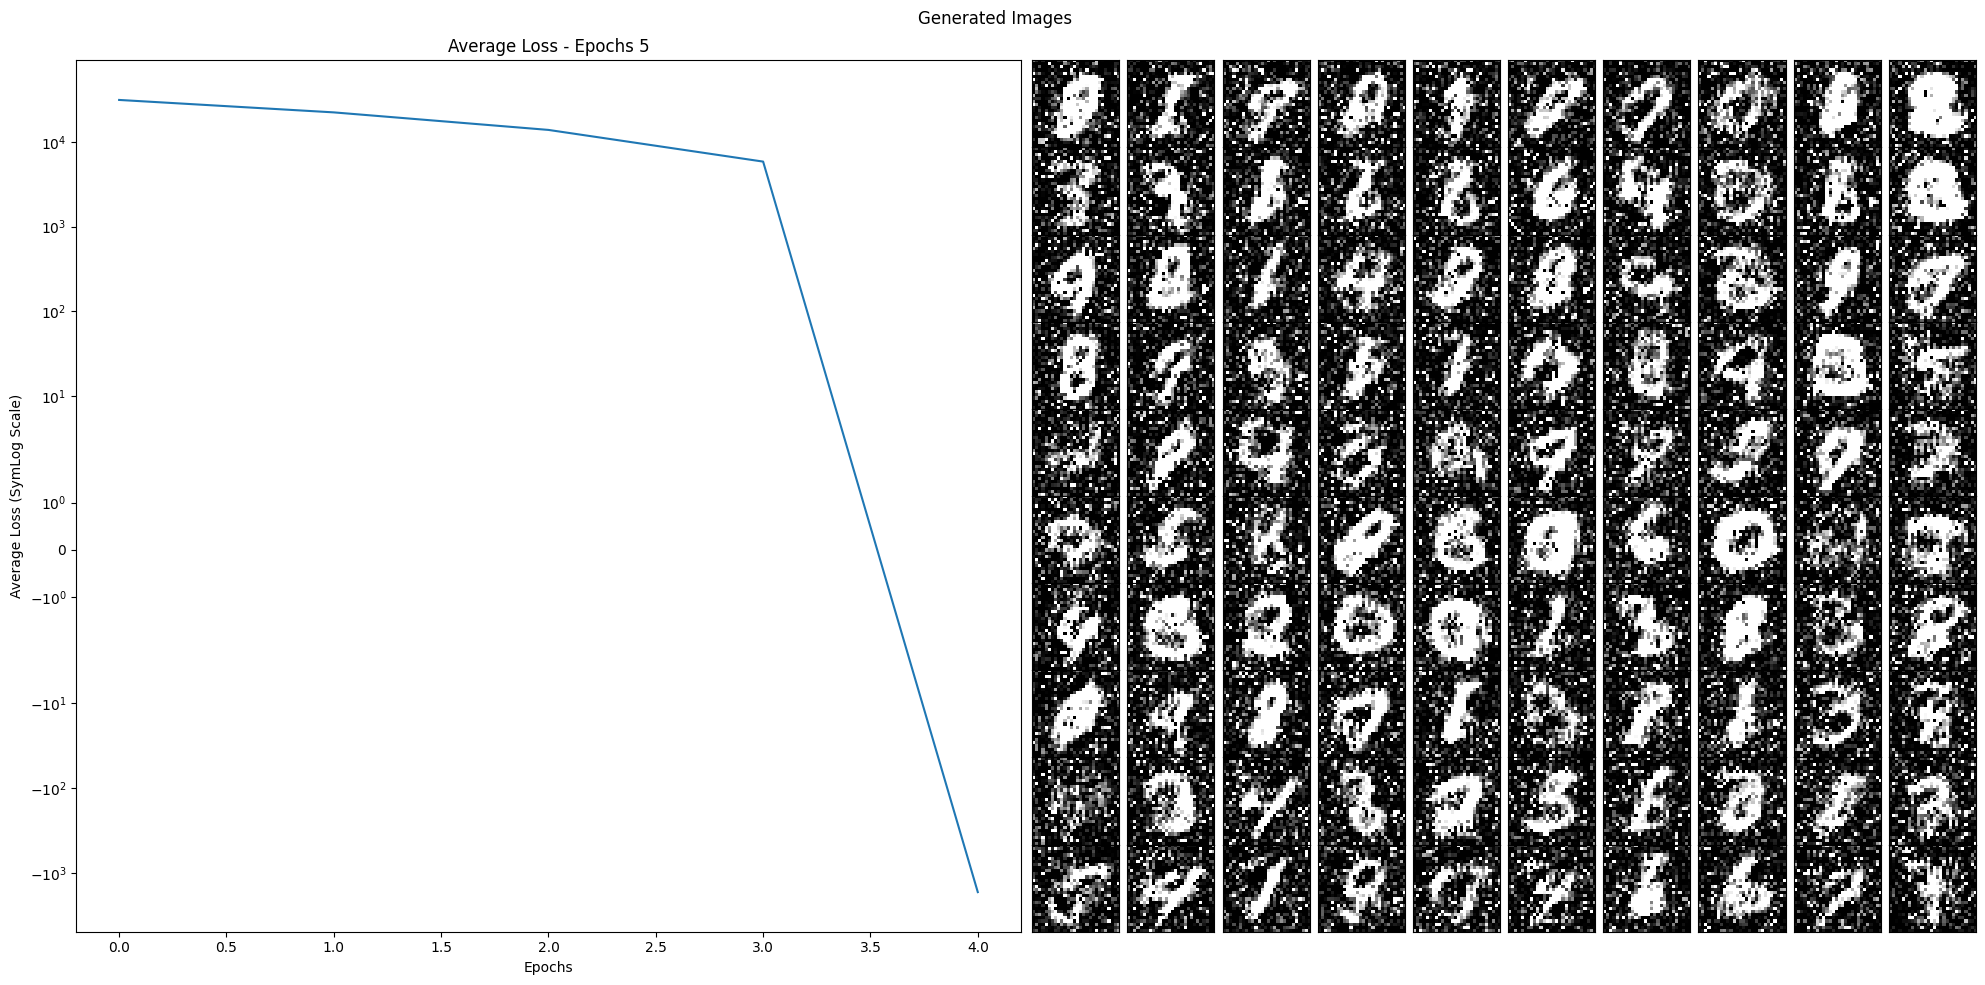

 10%|█         | 1/10 [00:53<08:03, 53.75s/it]

Epoch [1/10], avg_loss: 30806.2456


 20%|██        | 2/10 [01:47<07:09, 53.63s/it]

Epoch [2/10], avg_loss: 21810.0380


 30%|███       | 3/10 [02:41<06:16, 53.84s/it]

Epoch [3/10], avg_loss: 13310.3415


 40%|████      | 4/10 [03:34<05:21, 53.50s/it]

Epoch [4/10], avg_loss: 5229.7874


 50%|█████     | 5/10 [04:28<04:27, 53.58s/it]

Epoch [5/10], avg_loss: -2376.9798


 60%|██████    | 6/10 [05:22<03:35, 53.87s/it]

Epoch [6/10], avg_loss: -9439.3110


 70%|███████   | 7/10 [06:16<02:41, 53.77s/it]

Epoch [7/10], avg_loss: -15963.3816


 80%|████████  | 8/10 [07:10<01:48, 54.01s/it]

Epoch [8/10], avg_loss: -21988.4411


 90%|█████████ | 9/10 [08:04<00:53, 53.91s/it]

Epoch [9/10], avg_loss: -27533.6203


100%|██████████| 10/10 [08:57<00:00, 53.78s/it]


Epoch [10/10], avg_loss: -32605.0902


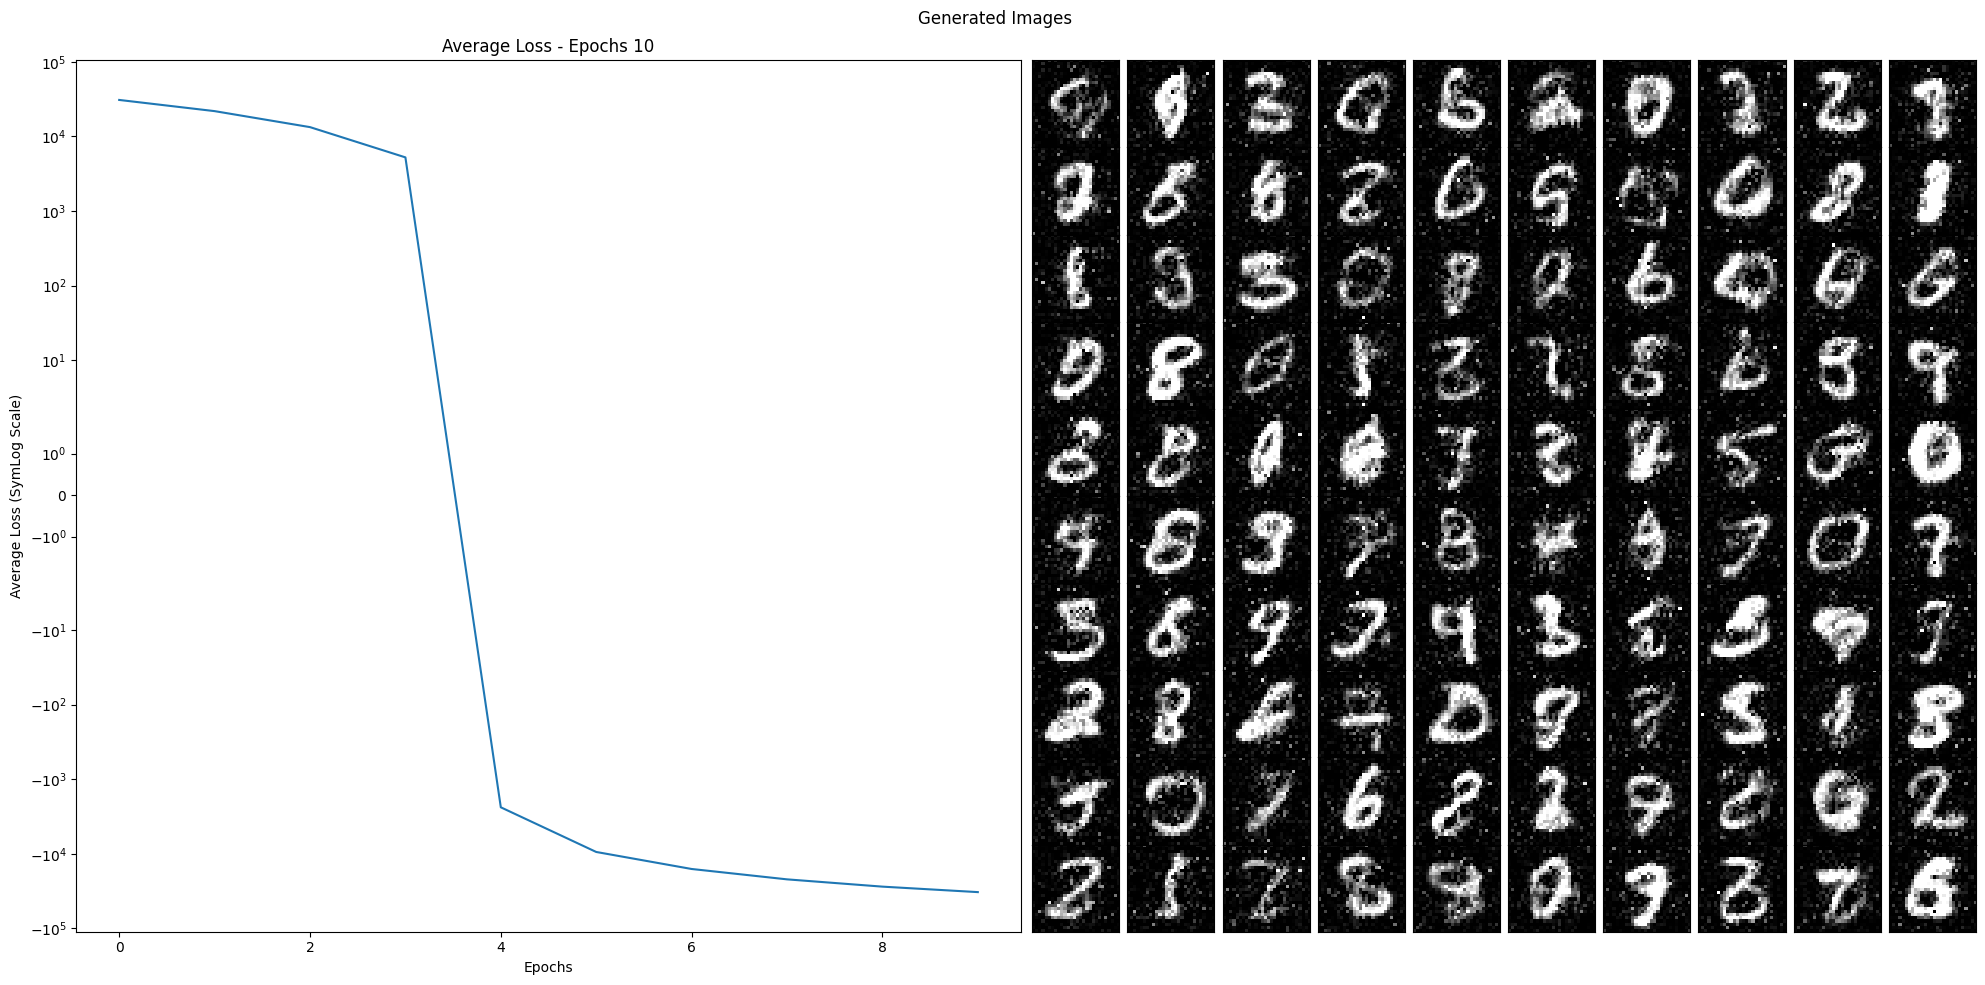

  7%|▋         | 1/15 [00:53<12:29, 53.54s/it]

Epoch [1/15], avg_loss: 32954.4914


 13%|█▎        | 2/15 [01:47<11:36, 53.61s/it]

Epoch [2/15], avg_loss: 23963.9660


 20%|██        | 3/15 [02:38<10:31, 52.66s/it]

Epoch [3/15], avg_loss: 15490.4282


 27%|██▋       | 4/15 [03:32<09:46, 53.28s/it]

Epoch [4/15], avg_loss: 7452.5148


 33%|███▎      | 5/15 [04:27<08:56, 53.65s/it]

Epoch [5/15], avg_loss: -176.6308


 40%|████      | 6/15 [05:21<08:04, 53.84s/it]

Epoch [6/15], avg_loss: -7357.1440


 47%|████▋     | 7/15 [06:15<07:11, 53.92s/it]

Epoch [7/15], avg_loss: -14025.7280


 53%|█████▎    | 8/15 [07:02<06:01, 51.66s/it]

Epoch [8/15], avg_loss: -20157.0464


 60%|██████    | 9/15 [07:27<04:19, 43.30s/it]

Epoch [9/15], avg_loss: -25803.0177


 67%|██████▋   | 10/15 [07:51<03:06, 37.37s/it]

Epoch [10/15], avg_loss: -30967.5305


 73%|███████▎  | 11/15 [08:26<02:26, 36.60s/it]

Epoch [11/15], avg_loss: -35640.9093


 80%|████████  | 12/15 [09:19<02:05, 41.80s/it]

Epoch [12/15], avg_loss: -39843.2979


 87%|████████▋ | 13/15 [10:13<01:30, 45.49s/it]

Epoch [13/15], avg_loss: -43606.7343


 93%|█████████▎| 14/15 [11:07<00:48, 48.02s/it]

Epoch [14/15], avg_loss: -46945.6536


100%|██████████| 15/15 [12:02<00:00, 48.17s/it]


Epoch [15/15], avg_loss: -49886.8880


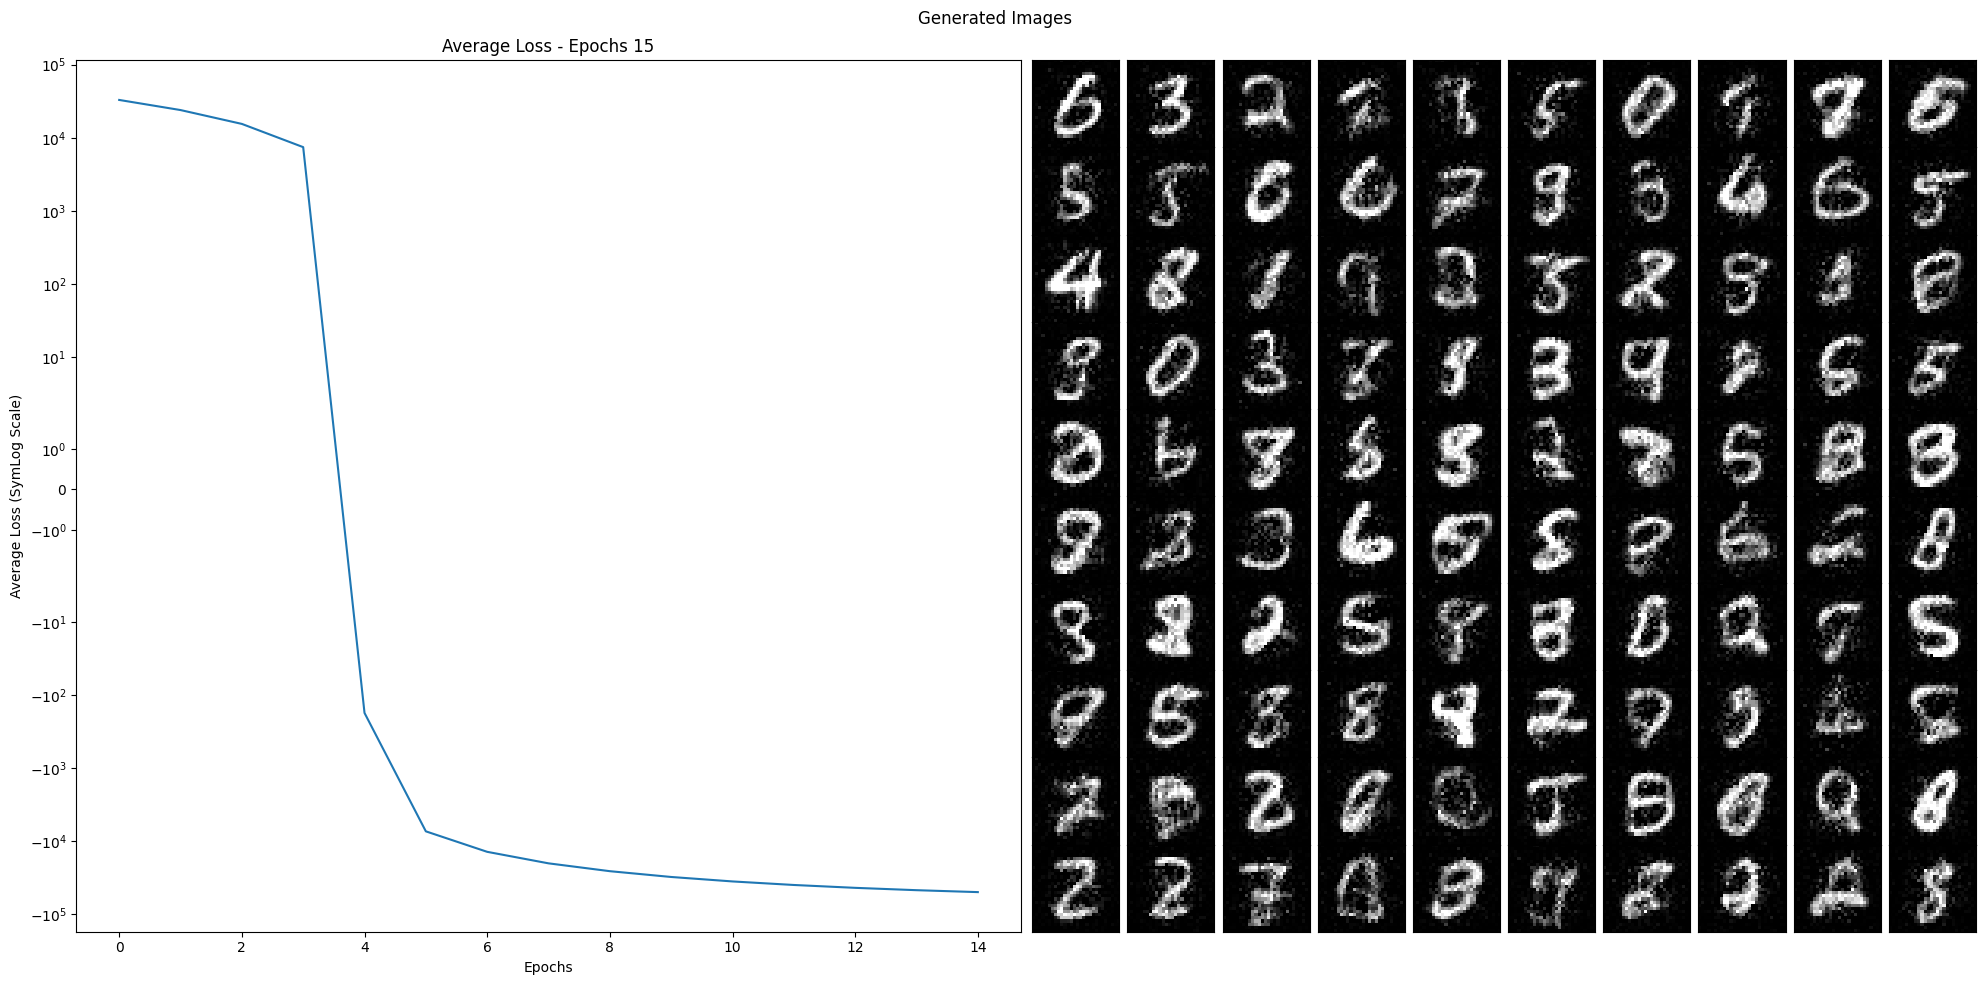

In [50]:
epoch_counts = [5, 10, 15]
for epochs in epoch_counts:
    normalizing_flow = NICE().to(device)
    optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
    dataloader = DataLoader(trainX, batch_size=32, shuffle=True)
    logistic_distribution = StandardLogisticDistribution(device=device)
    training_loss = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=epochs, device=device)
    plot_loss_and_images(training_loss, normalizing_flow, logistic_distribution, f"Epochs {epochs}")

Zadanie 3

In [34]:
class ModifiedNICE(nn.Module):
    def __init__(self, data_dim=28 * 28, hidden_dim=1000, num_layers=3, activation_fn=nn.ReLU):
        super().__init__()

        self.m = torch.nn.ModuleList()
        for i in range(4):
            layers = []
            for j in range(num_layers):
                in_dim = data_dim // 2 if j == 0 else hidden_dim
                out_dim = hidden_dim if j < num_layers - 1 else data_dim // 2
                layers.append(nn.Linear(in_dim, out_dim))
                if j < num_layers - 1: 
                    layers.append(activation_fn())
            self.m.append(nn.Sequential(*layers))

        self.s = torch.nn.Parameter(torch.randn(data_dim))

    def forward(self, x):
        x = x.clone()
        for i in range(len(self.m)):
            x_i1 = x[:, ::2] if (i % 2) == 0 else x[:, 1::2]
            x_i2 = x[:, 1::2] if (i % 2) == 0 else x[:, ::2]
            h_i1 = x_i1
            h_i2 = x_i2 + self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = h_i1
            x[:, 1::2] = h_i2
        z = torch.exp(self.s) * x
        log_jacobian = torch.sum(self.s)
        return z, log_jacobian

    def invert(self, z):
        x = z.clone() / torch.exp(self.s)
        for i in range(len(self.m) - 1, -1, -1):
            h_i1 = x[:, ::2]
            h_i2 = x[:, 1::2]
            x_i1 = h_i1
            x_i2 = h_i2 - self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = x_i1 if (i % 2) == 0 else x_i2
            x[:, 1::2] = x_i2 if (i % 2) == 0 else x_i1
        return x

In [42]:
normalizing_flow = ModifiedNICE(hidden_dim=500, num_layers=4, activation_fn=nn.LeakyReLU).to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=15,
                         device=device)

filename = 'modified_nf.sav'
pickle.dump(normalizing_flow, open(filename, 'wb'))

  7%|▋         | 1/15 [00:36<08:36, 36.90s/it]

Epoch [1/15], avg_loss: 30820.1886


 13%|█▎        | 2/15 [01:23<09:16, 42.82s/it]

Epoch [2/15], avg_loss: 21630.9203


 20%|██        | 3/15 [02:18<09:39, 48.31s/it]

Epoch [3/15], avg_loss: 12820.3678


 27%|██▋       | 4/15 [03:14<09:22, 51.10s/it]

Epoch [4/15], avg_loss: 4405.8933


 33%|███▎      | 5/15 [04:09<08:45, 52.57s/it]

Epoch [5/15], avg_loss: -3485.7755


 40%|████      | 6/15 [05:04<08:02, 53.58s/it]

Epoch [6/15], avg_loss: -10725.6761


 47%|████▋     | 7/15 [06:00<07:13, 54.18s/it]

Epoch [7/15], avg_loss: -17253.4902


 53%|█████▎    | 8/15 [06:55<06:21, 54.45s/it]

Epoch [8/15], avg_loss: -23126.2772


 60%|██████    | 9/15 [07:50<05:27, 54.62s/it]

Epoch [9/15], avg_loss: -28393.0879


 67%|██████▋   | 10/15 [08:45<04:34, 54.92s/it]

Epoch [10/15], avg_loss: -33073.2857


 73%|███████▎  | 11/15 [09:25<03:21, 50.34s/it]

Epoch [11/15], avg_loss: -37243.7792


 80%|████████  | 12/15 [10:01<02:17, 45.89s/it]

Epoch [12/15], avg_loss: -40966.2295


 87%|████████▋ | 13/15 [10:35<01:24, 42.34s/it]

Epoch [13/15], avg_loss: -44284.9736


 93%|█████████▎| 14/15 [11:32<00:46, 46.75s/it]

Epoch [14/15], avg_loss: -47237.4378


100%|██████████| 15/15 [12:07<00:00, 48.53s/it]

Epoch [15/15], avg_loss: -49788.2577


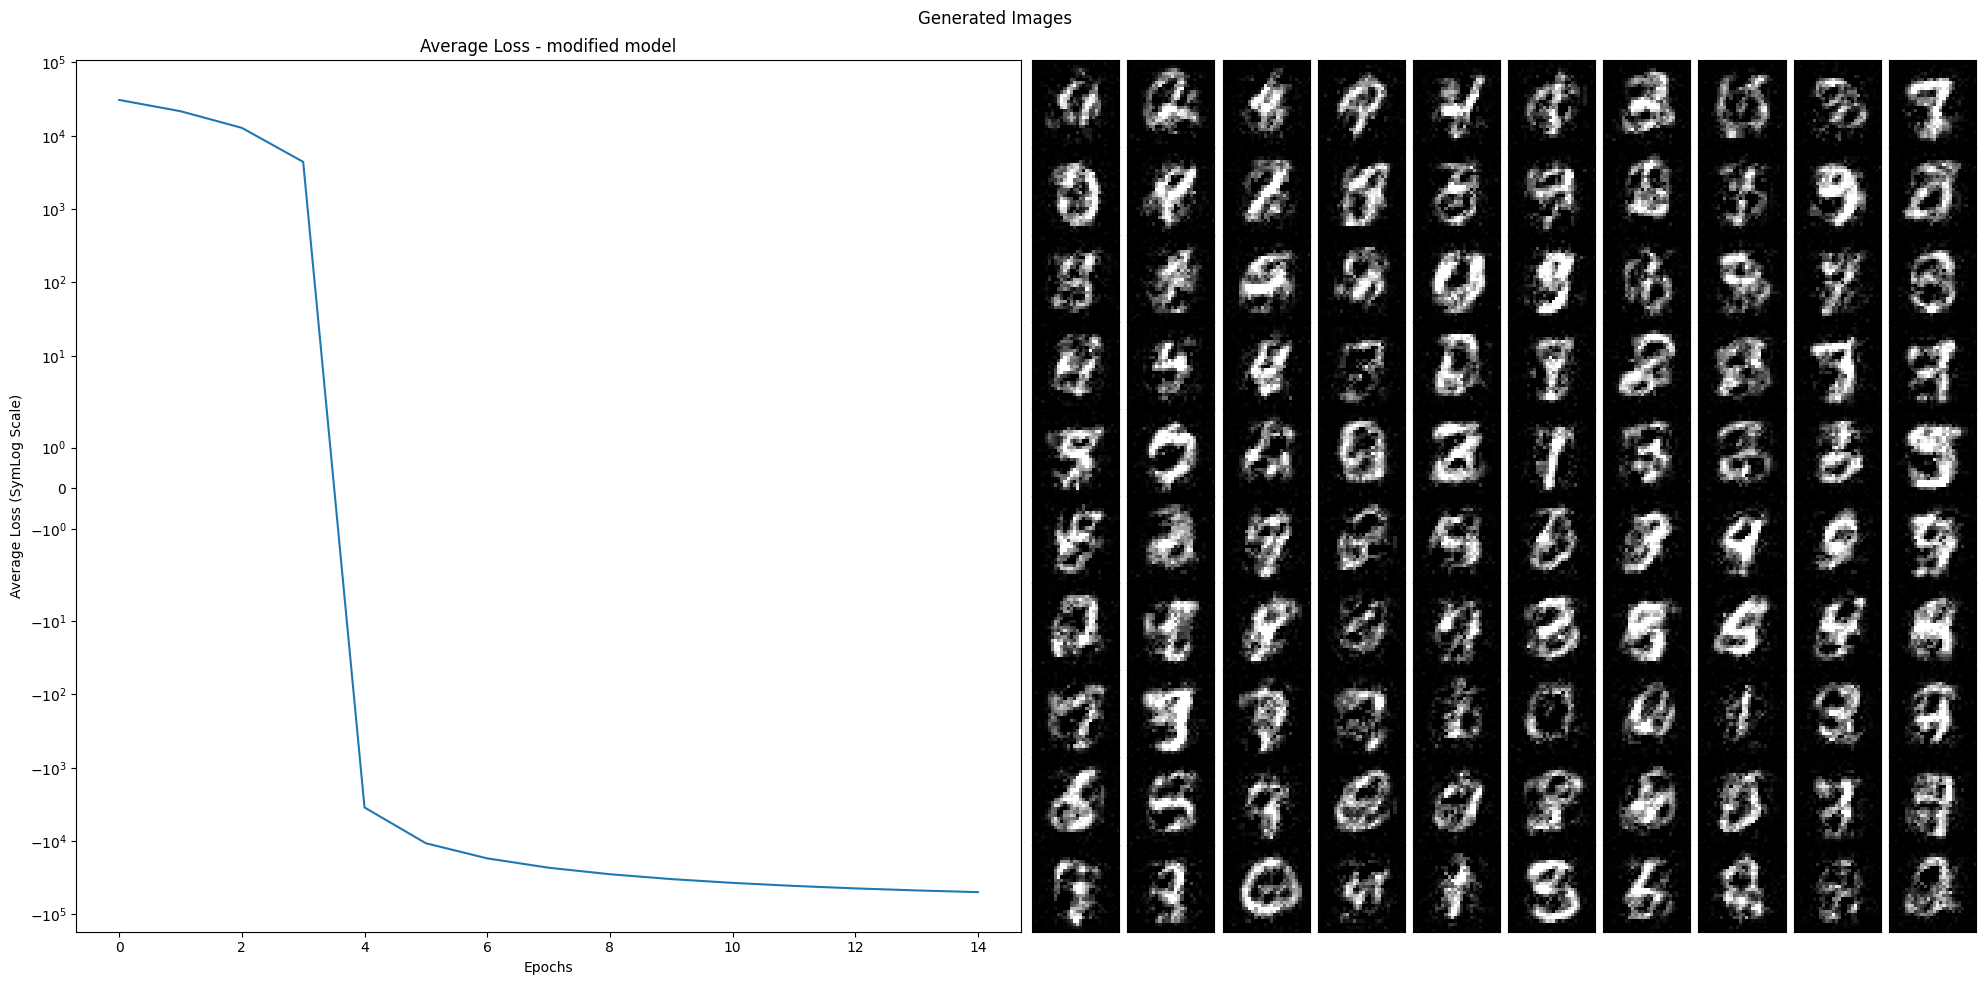

In [43]:
plot_loss_and_images(training_loss, normalizing_flow, logistic_distribution, "modified model")

Zadanie 4

MAF

In [57]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

class MADE(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, num_masks=1, natural_ordering=False):
        """
        nin: integer; number of inputs
        hidden sizes: a list of integers; number of units in hidden layers
        nout: integer; number of outputs, which usually collectively parameterize some kind of 1D distribution
              note: if nout is e.g. 2x larger than nin (perhaps the mean and std), then the first nin
              will be all the means and the second nin will be stds. i.e. output dimensions depend on the
              same input dimensions in "chunks" and should be carefully decoded downstream appropriately.
              the output of running the tests for this file makes this a bit more clear with examples.
        num_masks: can be used to train ensemble over orderings/connections
        natural_ordering: force natural ordering of dimensions, don't use random permutations
        """
        
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        assert self.nout % self.nin == 0, "nout must be integer multiple of nin"
        
        # define a simple MLP neural net
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.ReLU(),
                ])
        self.net.pop() # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net)
        
        # seeds for orders/connectivities of the model ensemble
        self.natural_ordering = natural_ordering
        self.num_masks = num_masks
        self.seed = 0 # for cycling through num_masks orderings
        
        self.m = {}
        self.update_masks() # builds the initial self.m connectivity
        # note, we could also precompute the masks and cache them, but this
        # could get memory expensive for large number of masks.
        
    def update_masks(self):
        if self.m and self.num_masks == 1: return # only a single seed, skip for efficiency
        L = len(self.hidden_sizes)
        
        # fetch the next seed and construct a random stream
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks
        
        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin) if self.natural_ordering else rng.permutation(self.nin)
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_sizes[l])
        
        # construct the mask matrices
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        # handle the case where nout = nin * k, for integer k > 1
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            # replicate the mask across the other outputs
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)
        
        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        return self.net(x)

In [59]:
class ARMLP(nn.Module):
    """ a 4-layer auto-regressive MLP, wrapper around MADE net """

    def __init__(self, nin, nout, nh):
        super().__init__()
        self.net = MADE(nin, [nh, nh, nh], nout, num_masks=1, natural_ordering=True)
        
    def forward(self, x):
        return self.net(x)

In [60]:
class MAF(nn.Module):
    """ Masked Autoregressive Flow that uses a MADE-style network for fast forward """
    
    def __init__(self, dim, parity, net_class=ARMLP, nh=24):
        super().__init__()
        self.dim = dim
        self.net = net_class(dim, dim*2, nh)
        self.parity = parity

    def forward(self, x):
        # here we see that we are evaluating all of z in parallel, so density estimation will be fast
        st = self.net(x)
        s, t = st.split(self.dim, dim=1)
        z = x * torch.exp(s) + t
        # reverse order, so if we stack MAFs correct things happen
        z = z.flip(dims=(1,)) if self.parity else z
        log_det = torch.sum(s, dim=1)
        return z, log_det
    
    def backward(self, z):
        # we have to decode the x one at a time, sequentially
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.size(0))
        z = z.flip(dims=(1,)) if self.parity else z
        for i in range(self.dim):
            st = self.net(x.clone()) # clone to avoid in-place op errors if using IAF
            s, t = st.split(self.dim, dim=1)
            x[:, i] = (z[:, i] - t[:, i]) * torch.exp(-s[:, i])
            log_det += -s[:, i]
        return x, log_det

In [43]:
def train_model(model, optimizer, train_loader, distribution, epochs=30, device='cpu'):
    model.train()
    avg_losses = [] 

    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            z, log_jacobian = model(batch)
            
            log_likelihood = distribution.log_pdf(z) + log_jacobian
            loss = -log_likelihood.sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        avg_losses.append(avg_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.4f}")

    return avg_losses

In [36]:
normalizing_flow = MAF(dim=28 * 28, parity=True).to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss = train_model(normalizing_flow, optimizer, dataloader, logistic_distribution)

filename = 'MAF.sav'
pickle.dump(normalizing_flow, open(filename, 'wb'))

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:26<03:59, 26.63s/it]

Epoch [1/10], Train Loss: 135.8943


 20%|██        | 2/10 [01:08<04:46, 35.78s/it]

Epoch [2/10], Train Loss: -25158.0333


 30%|███       | 3/10 [01:59<04:59, 42.75s/it]

Epoch [3/10], Train Loss: -29357.5398


 40%|████      | 4/10 [02:38<04:06, 41.12s/it]

Epoch [4/10], Train Loss: -33145.6738


 50%|█████     | 5/10 [03:29<03:43, 44.64s/it]

Epoch [5/10], Train Loss: -36301.8928


 60%|██████    | 6/10 [04:17<03:03, 45.90s/it]

Epoch [6/10], Train Loss: -38930.9366


 70%|███████   | 7/10 [05:15<02:29, 49.73s/it]

Epoch [7/10], Train Loss: -40892.2864


 80%|████████  | 8/10 [06:31<01:56, 58.00s/it]

Epoch [8/10], Train Loss: -42533.8322


 90%|█████████ | 9/10 [07:48<01:03, 63.99s/it]

Epoch [9/10], Train Loss: -43991.3069


100%|██████████| 10/10 [08:44<00:00, 52.42s/it]

Epoch [10/10], Train Loss: -45377.2235


In [33]:
def plot_loss_and_images_maf(training_loss, normalizing_flow, logistic_distribution, title, nb_data=10):
    fig = plt.figure(figsize=(20, 10))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(training_loss)
    ax1.set_yscale('symlog')
    ax1.set_title(f'Average Loss - {title}')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Average Loss (SymLog Scale)')

    outer_grid = gridspec.GridSpec(1, 2, wspace=0.0, hspace=0.0)[1]
    inner_grid = gridspec.GridSpecFromSubplotSpec(nb_data, nb_data, subplot_spec=outer_grid, wspace=0.0, hspace=0.0)

    for i in range(nb_data * nb_data):
        ax = plt.Subplot(fig, inner_grid[i])
        z_sample = logistic_distribution.sample().unsqueeze(0)
        x, _ = normalizing_flow.backward(z_sample)
        ax.imshow(x.data.cpu().numpy().reshape(28, 28).clip(0, 1), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

    plt.suptitle('Generated Images')
    plt.tight_layout()
    plt.savefig(f'{title}_NF_Training_and_Generated_Images.png')
    plt.show()

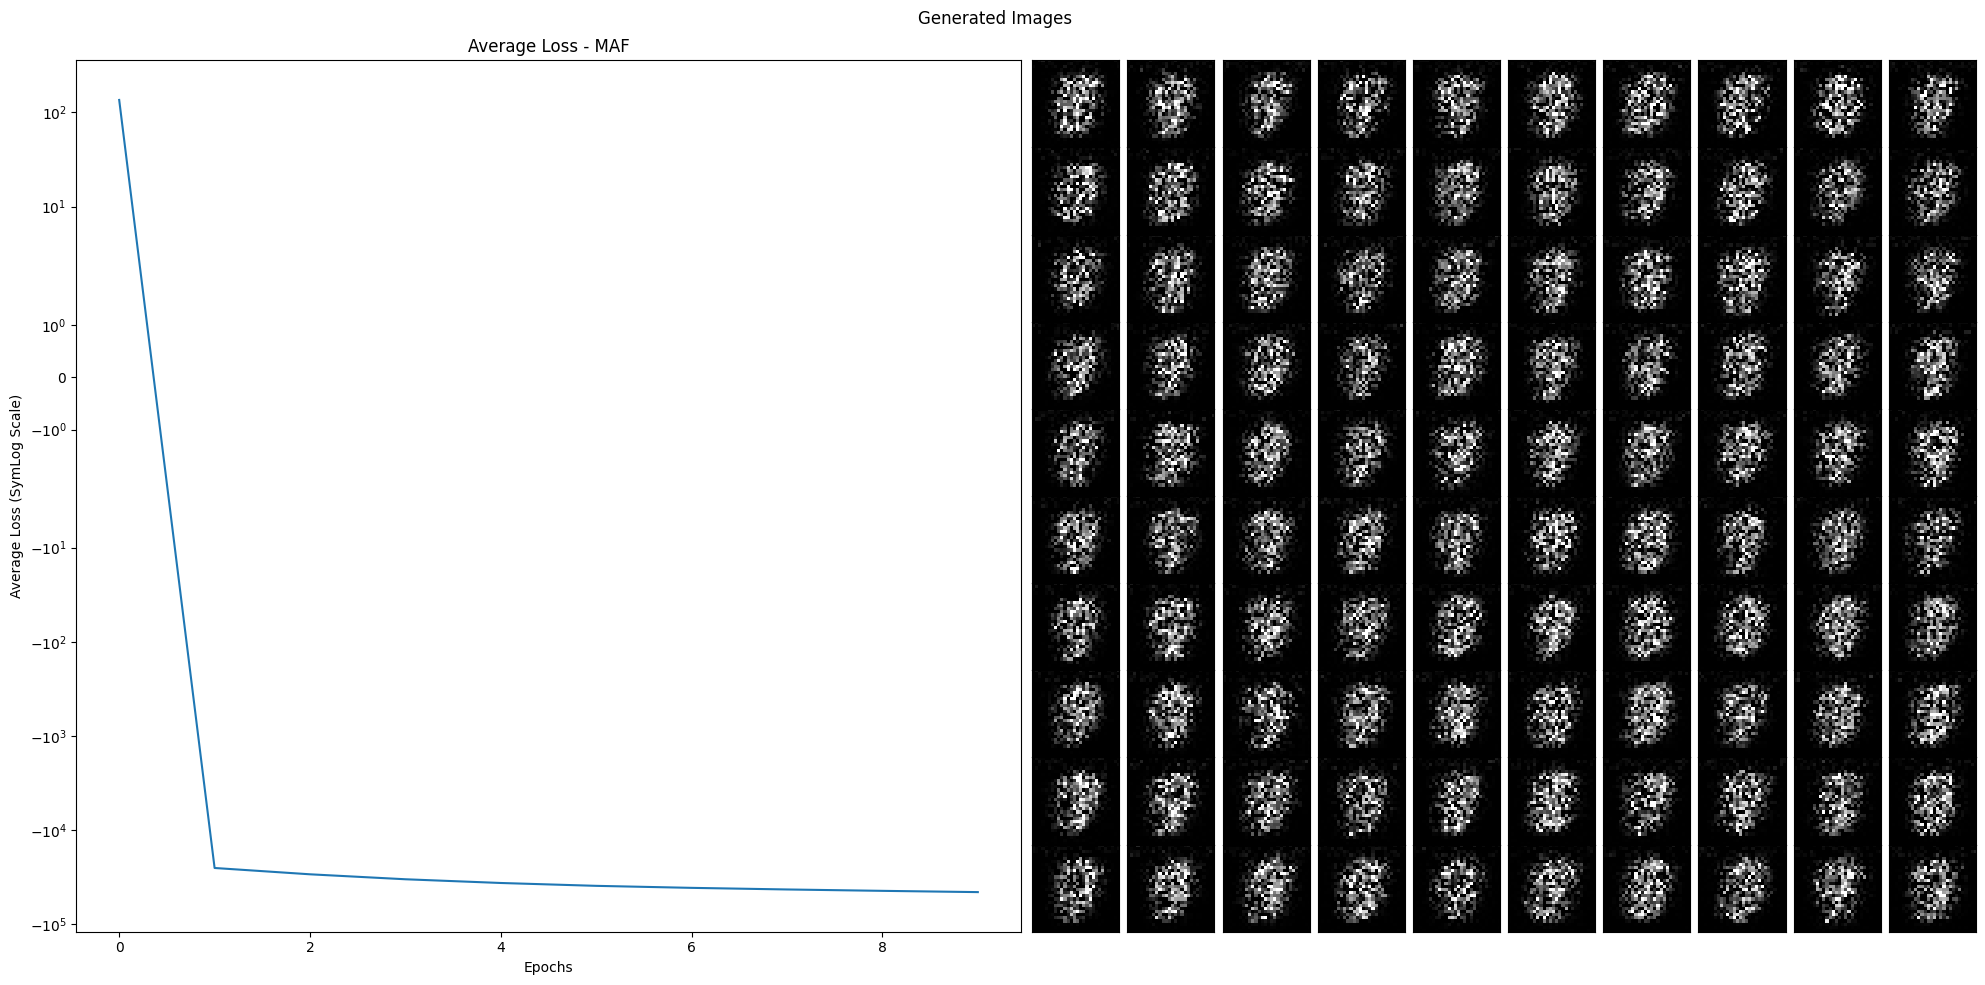

In [37]:
plot_loss_and_images_maf(training_loss, normalizing_flow, logistic_distribution, "MAF")

AHF

In [38]:
class MLP(nn.Module):
    """ a simple 4-layer MLP """

    def __init__(self, nin, nout, nh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nin, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nout),
        )
    def forward(self, x):
        return self.net(x)

In [39]:
class AffineHalfFlow(nn.Module):
    """
    As seen in RealNVP, affine autoregressive flow (z = x * exp(s) + t), where half of the 
    dimensions in x are linearly scaled/transfromed as a function of the other half.
    Which half is which is determined by the parity bit.
    - RealNVP both scales and shifts (default)
    - NICE only shifts
    """
    def __init__(self, dim, parity, net_class=MLP, nh=24, scale=True, shift=True):
        super().__init__()
        self.dim = dim
        self.parity = parity
        self.s_cond = lambda x: x.new_zeros(x.size(0), self.dim // 2)
        self.t_cond = lambda x: x.new_zeros(x.size(0), self.dim // 2)
        if scale:
            self.s_cond = net_class(self.dim // 2, self.dim // 2, nh)
        if shift:
            self.t_cond = net_class(self.dim // 2, self.dim // 2, nh)
        
    def forward(self, x):
        x0, x1 = x[:,::2], x[:,1::2]
        if self.parity:
            x0, x1 = x1, x0
        s = self.s_cond(x0)
        t = self.t_cond(x0)
        z0 = x0 # untouched half
        z1 = torch.exp(s) * x1 + t # transform this half as a function of the other
        if self.parity:
            z0, z1 = z1, z0
        z = torch.cat([z0, z1], dim=1)
        log_det = torch.sum(s, dim=1)
        return z, log_det
    
    def backward(self, z):
        z0, z1 = z[:,::2], z[:,1::2]
        if self.parity:
            z0, z1 = z1, z0
        s = self.s_cond(z0)
        t = self.t_cond(z0)
        x0 = z0 # this was the same
        x1 = (z1 - t) * torch.exp(-s) # reverse the transform on this half
        if self.parity:
            x0, x1 = x1, x0
        x = torch.cat([x0, x1], dim=1)
        log_det = torch.sum(-s, dim=1)
        return x, log_det

In [44]:
normalizing_flow = AffineHalfFlow(dim=28 * 28,  parity=False).to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss = train_model(normalizing_flow, optimizer, dataloader, logistic_distribution)

filename = 'AHF.sav'
pickle.dump(normalizing_flow, open(filename, 'wb'))

  3%|▎         | 1/30 [00:19<09:12, 19.04s/it]

Epoch [1/30], Train Loss: 4498.0668


  7%|▋         | 2/30 [00:38<09:06, 19.51s/it]

Epoch [2/30], Train Loss: -3283.5213


 10%|█         | 3/30 [01:01<09:30, 21.13s/it]

Epoch [3/30], Train Loss: -7725.0321


 13%|█▎        | 4/30 [01:25<09:37, 22.20s/it]

Epoch [4/30], Train Loss: -9292.8722


 17%|█▋        | 5/30 [01:48<09:17, 22.28s/it]

Epoch [5/30], Train Loss: -9807.6176


 20%|██        | 6/30 [02:10<08:57, 22.41s/it]

Epoch [6/30], Train Loss: -11370.7301


 23%|██▎       | 7/30 [02:32<08:32, 22.27s/it]

Epoch [7/30], Train Loss: -14216.0253


 27%|██▋       | 8/30 [02:54<08:08, 22.21s/it]

Epoch [8/30], Train Loss: -15163.6014


 30%|███       | 9/30 [03:14<07:30, 21.45s/it]

Epoch [9/30], Train Loss: -15624.4347


 33%|███▎      | 10/30 [03:36<07:11, 21.58s/it]

Epoch [10/30], Train Loss: -16059.2052


 37%|███▋      | 11/30 [03:58<06:51, 21.66s/it]

Epoch [11/30], Train Loss: -16597.9744


 40%|████      | 12/30 [04:19<06:25, 21.44s/it]

Epoch [12/30], Train Loss: -17152.1373


 43%|████▎     | 13/30 [04:38<05:55, 20.89s/it]

Epoch [13/30], Train Loss: -17615.9652


 47%|████▋     | 14/30 [04:52<05:00, 18.77s/it]

Epoch [14/30], Train Loss: -18009.5341


 50%|█████     | 15/30 [05:03<04:03, 16.26s/it]

Epoch [15/30], Train Loss: -18354.0820


 53%|█████▎    | 16/30 [05:14<03:26, 14.74s/it]

Epoch [16/30], Train Loss: -18671.4542


 57%|█████▋    | 17/30 [05:23<02:49, 13.05s/it]

Epoch [17/30], Train Loss: -18954.0132


 60%|██████    | 18/30 [05:32<02:23, 11.94s/it]

Epoch [18/30], Train Loss: -19193.6554


 63%|██████▎   | 19/30 [05:44<02:09, 11.76s/it]

Epoch [19/30], Train Loss: -19400.8099


 67%|██████▋   | 20/30 [05:54<01:53, 11.33s/it]

Epoch [20/30], Train Loss: -19583.0085


 70%|███████   | 21/30 [06:03<01:35, 10.64s/it]

Epoch [21/30], Train Loss: -19729.7851


 73%|███████▎  | 22/30 [06:12<01:21, 10.22s/it]

Epoch [22/30], Train Loss: -19857.2624


 77%|███████▋  | 23/30 [06:22<01:09,  9.88s/it]

Epoch [23/30], Train Loss: -19978.5384


 80%|████████  | 24/30 [06:31<00:58,  9.74s/it]

Epoch [24/30], Train Loss: -20101.3407


 83%|████████▎ | 25/30 [06:41<00:49,  9.96s/it]

Epoch [25/30], Train Loss: -20228.9389


 87%|████████▋ | 26/30 [06:52<00:40, 10.19s/it]

Epoch [26/30], Train Loss: -20363.9744


 90%|█████████ | 27/30 [07:02<00:30, 10.10s/it]

Epoch [27/30], Train Loss: -20497.8821


 93%|█████████▎| 28/30 [07:11<00:19,  9.83s/it]

Epoch [28/30], Train Loss: -20629.5678


 97%|█████████▋| 29/30 [07:21<00:09,  9.69s/it]

Epoch [29/30], Train Loss: -20757.0807


100%|██████████| 30/30 [07:30<00:00, 15.02s/it]

Epoch [30/30], Train Loss: -20876.3449


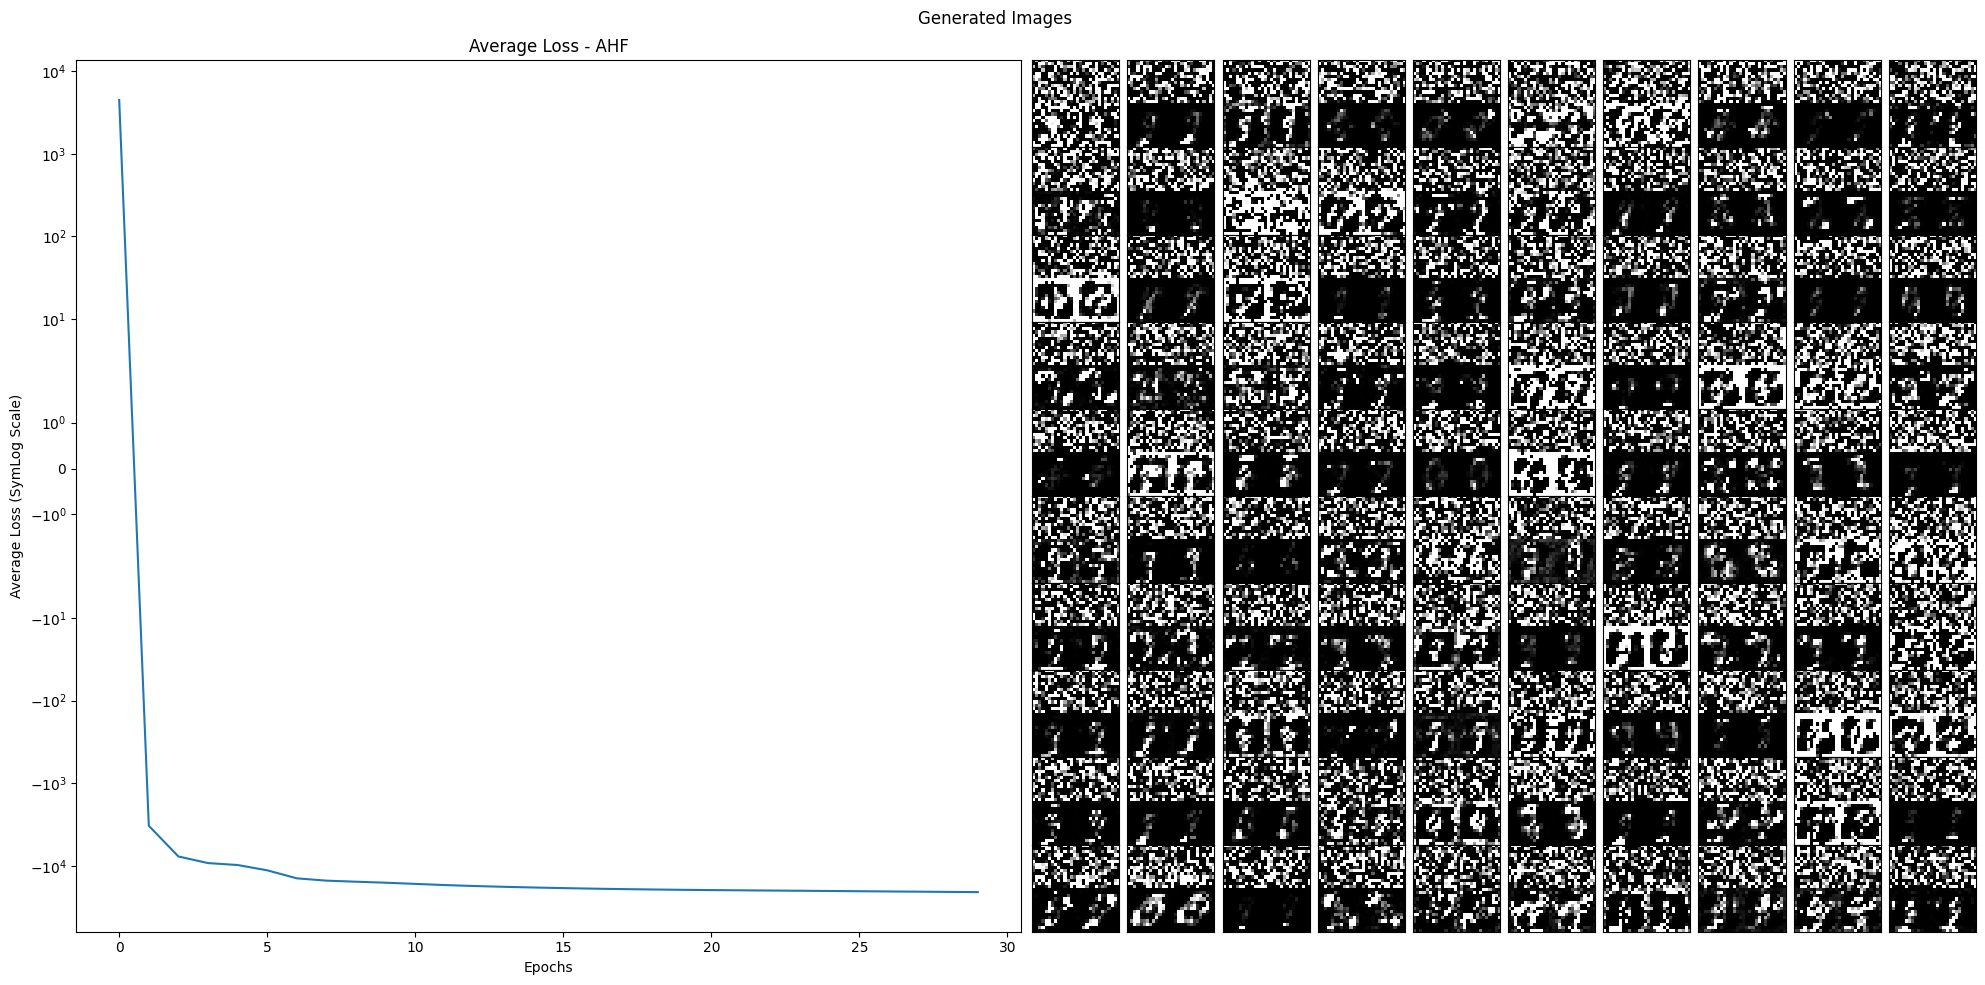

In [45]:
plot_loss_and_images_maf(training_loss, normalizing_flow, logistic_distribution, "AHF")

Zad 5

NICE evaluation

In [16]:
from sklearn.manifold import TSNE  
from torch.utils.data import TensorDataset

def perform_tsne(model, labels):
    model.eval()

    trainY_tensor = torch.tensor(trainY)

    dataset = TensorDataset(trainX, trainY_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    outputs = []
    all_labels = []
    with torch.no_grad():
        for batch, label in dataloader:
            batch = batch.to(device)
            batch_output, _ = model(batch)
            outputs.append(batch_output)
            all_labels.append(label)

    outputs = torch.cat(outputs, dim=0).cpu().numpy()
    all_labels = np.concatenate(all_labels)

    tsne = TSNE(n_components=2, random_state=123)
    tsne_results = tsne.fit_transform(outputs)

    plt.figure(figsize=(10, 6))
    for label in np.unique(all_labels):
        indices = all_labels == label
        plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=label, alpha=0.5)
    plt.title('t-SNE Visualization of Model Outputs')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()  
    plt.show()

In [18]:
def generate_images(model, num_images, device):
    z_samples = torch.randn(num_images, 28*28).to(device)
    generated_images = model.invert(z_samples)
    return generated_images

In [53]:
from torchvision.models import inception_v3
import torch.nn.functional as F

def inception_score(inception_model, device='cpu', batch_size=32, splits=10):
    
    def get_pred(x):
        x = x.view(-1, 1, 28, 28)
        x = x.repeat(1, 3, 1, 1)
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        with torch.no_grad():
            x = inception_model(x.to(device))
        return F.softmax(x, dim=1).data

    N = len(dataloader.dataset)

    preds = torch.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.to(device)
        batch_size_i = batch.size()[0]

        preds[i * batch_size : i * batch_size + batch_size_i] = get_pred(batch)[:batch_size_i]

    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = torch.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(F.kl_div(py.log(), pyx, reduction='sum').item())
        split_scores.append(torch.exp(torch.tensor(scores).mean()))

    return torch.mean(torch.tensor(split_scores)), torch.std(torch.tensor(split_scores))

inception_model = inception_v3(pretrained=True, transform_input=False).to('cpu')
inception_model.eval()

c:\Users\Iga Miller\OneDrive\Pulpit\lista-3-9-15-11-00-Iga-Miller\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Iga Miller\OneDrive\Pulpit\lista-3-9-15-11-00-Iga-Miller\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

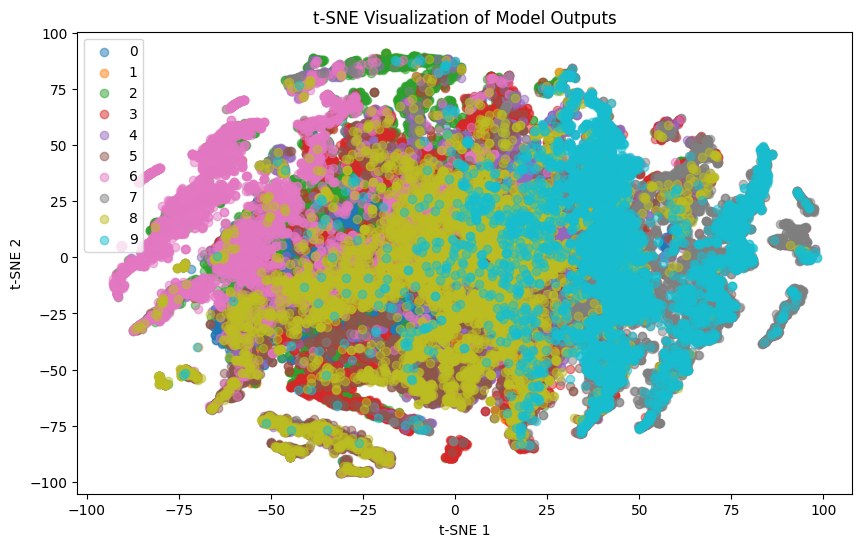

In [17]:
nice = pickle.load(open('nice.sav', 'rb')).to(device)

perform_tsne(nice, trainY)

In [32]:
from torch.utils.data import TensorDataset, DataLoader

device = 'cuda'

num_images_to_generate = 100
generated_images = generate_images(nice, num_images_to_generate, device)

generated_images_loader = DataLoader(generated_images, batch_size=32, shuffle=True)

batch_size = 32
splits = 10

score_mean, score_std = inception_score(inception_model, device=device, batch_size=batch_size, splits=splits)

print(score_mean)
print(score_std)

tensor(2.3329)
tensor(0.0212)


Modified NICE evaluation

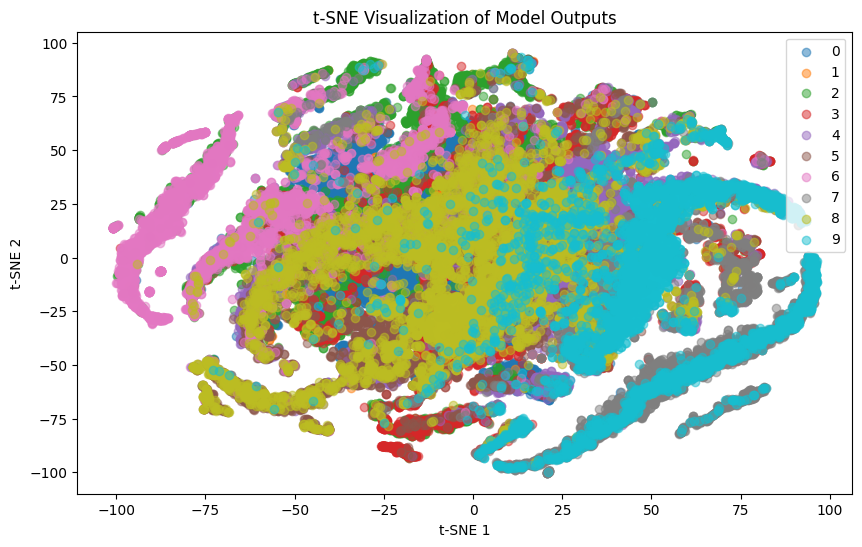

In [35]:
modified_nice = pickle.load(open('modified_nf.sav', 'rb')).to(device)

perform_tsne(modified_nice, trainY)

In [36]:
device = 'cuda'

num_images_to_generate = 100
generated_images = generate_images(modified_nice, num_images_to_generate, device)

generated_images_loader = DataLoader(generated_images, batch_size=32, shuffle=True)

batch_size = 32
splits = 10

score_mean, score_std = inception_score(inception_model, device=device, batch_size=batch_size, splits=splits)

print(score_mean)
print(score_std)

tensor(2.3331)
tensor(0.0218)


AHF evaluation

In [40]:
ahf = pickle.load(open('AHF.sav', 'rb'))

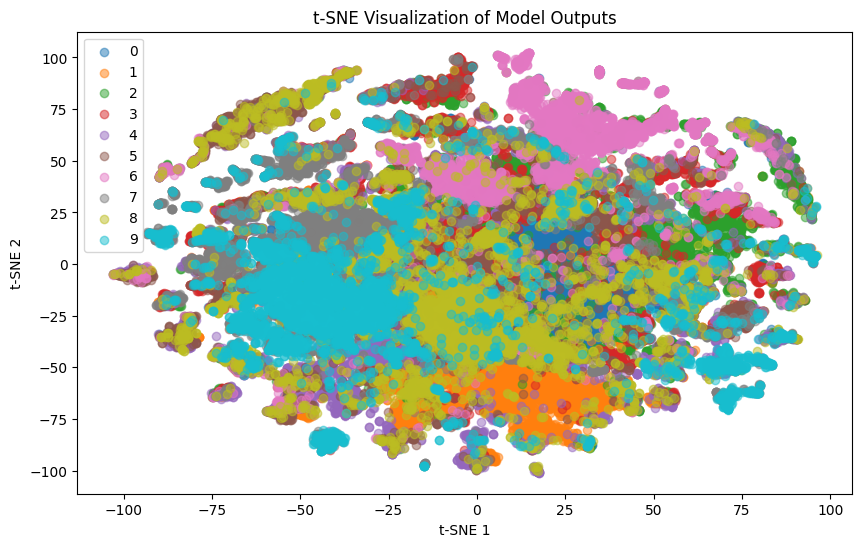

In [68]:
perform_tsne(ahf, trainY)

In [51]:
device = 'cpu'

def generate_images(model, num_images, device):
    z_samples = torch.randn(num_images, 28*28).to(device)
    generated_images, _ = model.backward(z_samples)
    return generated_images

In [ ]:
num_images_to_generate = 100
generated_images = generate_images(ahf, num_images_to_generate, device)

generated_images_loader = DataLoader(generated_images, batch_size=32, shuffle=True)

batch_size = 32
splits = 10

score_mean, score_std = inception_score(inception_model, device=device, batch_size=batch_size, splits=splits)

print(score_mean)
print(score_std)


MAF evaluation

In [61]:
maf = pickle.load(open('MAF.sav', 'rb'))

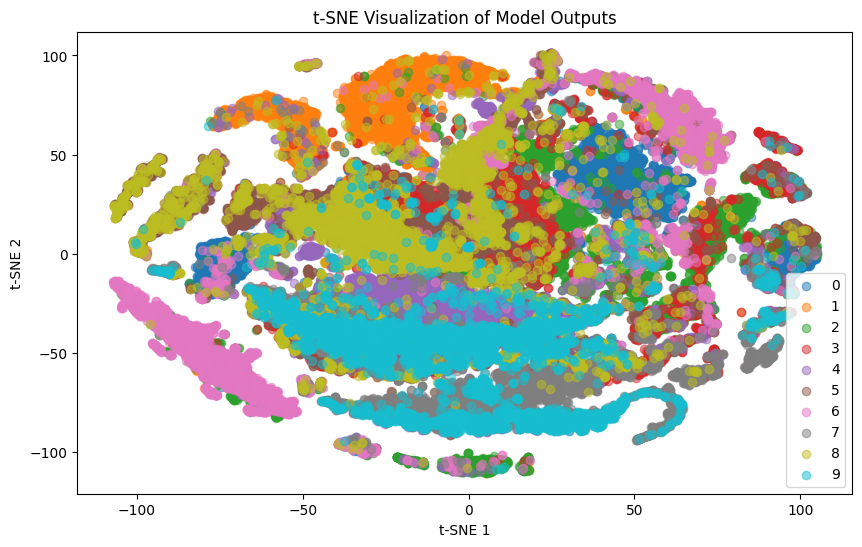

In [62]:
perform_tsne(maf, trainY)

In [ ]:
num_images_to_generate = 100
generated_images = generate_images(maf, num_images_to_generate, device)

generated_images_loader = DataLoader(generated_images, batch_size=32, shuffle=True)

batch_size = 32
splits = 10

score_mean, score_std = inception_score(inception_model, device=device, batch_size=batch_size, splits=splits)

print(score_mean)
print(score_std)